In [360]:
from trainer import Trainer
from zytlib import vector, path
from zytlib import Logger
from zytlib.table import table
from zytlib.visual.animation import TimeStamp, ScatterAnimation
from tqdm import tqdm
import argparse
import torch
from torchfunction.device import todevice, get_device
from matplotlib import pyplot as plt
import seaborn as sns
import functools
import numpy as np
from matplotlib.animation import FuncAnimation
from matplotlib import animation
from utils import SOR
from torchfunction.inspect import get_shape
from collections import OrderedDict
import math
from zytlib import logging
%config InlineBackend.figure_format = 'svg'
device = get_device("cuda")

In [362]:
model_name = "2021-1222-14-2"
model = Trainer.load(f"model/2021-1222-14-2.pt", datapath="dataset/dataset_item_2_test_rank123.db")

max_epochs: "1000"
learning_rate: "0.001"
datapath: ""dataset/dataset_item_2_train_length_123.db""
embedding: ""dataset/embedding_inputdim_2_embeddingdim_4096_round_without_normalize.db""
encoder_max_rank: "3"
load_model_path: ""model/checkpoint/2021-1221-14-2./2021-1221-14-2_999.pt""
freeze_parameter: "['decoder']"
save_model_every_epoch_num: "1"
residual_loss: "0.001"
train_items_crop: "2"
lr_final_decay: "0.01"


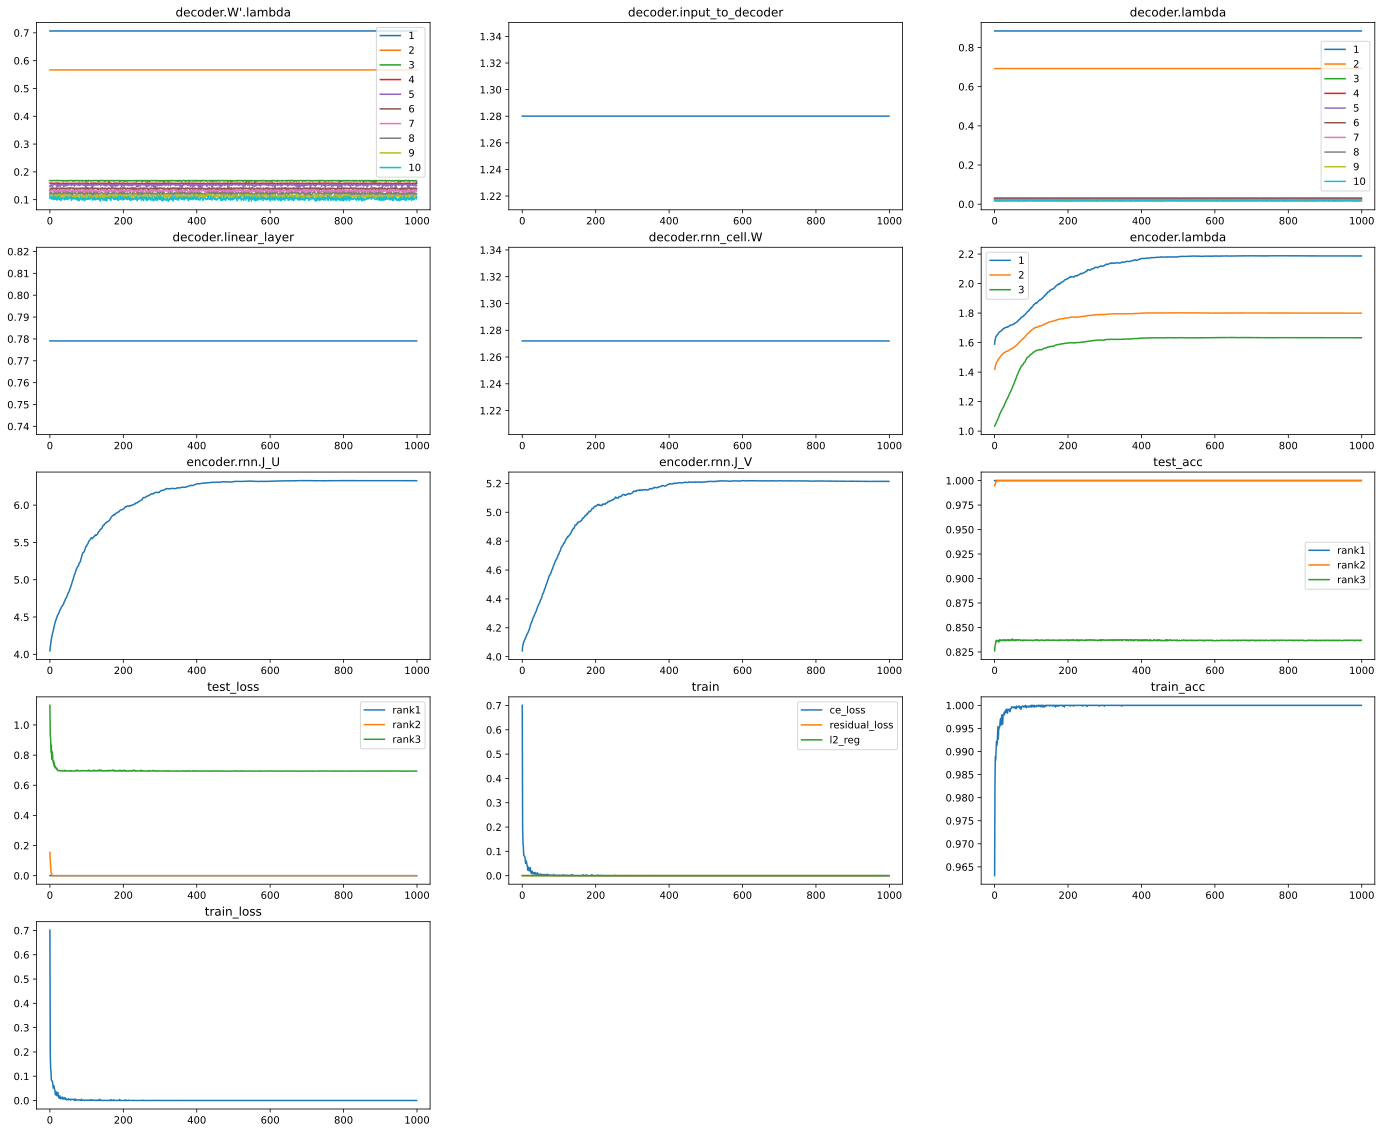

True

In [5]:
# python main.py --datapath dataset/dataset_item_2_train_length_123.db --learning_rate 0.001 --lr_final_decay 0.01 --l2_reg 1e-5 --encoder_max_rank 3 --max_epochs 1000 --load_model_path model/checkpoint/2021-1221-14-2./2021-1221-14-2_999.pt --freeze_parameter decoder --embedding dataset/embedding_inputdim_2_embeddingdim_4096_round_without_normalize.db --residual_loss 1e-3 --train_items_crop 2 --save_model_every_epoch_num 1
log_file = 'Log/2021-1222-14-2.log'
variable_dict = logging.Logger.variable_from_logging_file(log_file)
parser_dict = logging.Logger.parser_from_logging_file(log_file)
parser_dict.specified.pretty_print()
logging.Logger.plot_variable_dict(variable_dict)

In [6]:
media_path = path(f"media/{model_name}").mkdir()
figure_path = path(f"figure/{model_name}").mkdir()

In [7]:
model.encoder.eval()
model.decoder.eval()
model.encoder.rnn(torch.zeros(32, model.hyper.embedding_dim).to(device), torch.zeros(32, model.hyper.embedding_dim).to(device))

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0',
       grad_fn=<AddBackward0>)

In [8]:
model.named_parameters()

[('encoder.rnn._J_V', Parameter containing:
tensor([[-0.8866, -1.8812,  0.2904],
        [ 2.6942,  0.0412,  0.7686],
        [-1.0326, -1.1124,  0.4025],
        ...,
        [ 1.2195, -0.4202,  1.2685],
        [ 0.1381, -0.7026,  1.0471],
        [-1.3455,  1.1159, -2.8492]], device='cuda:0', requires_grad=True)), ('encoder.rnn._J_U', Parameter containing:
tensor([[-0.2036, -1.7799,  0.1501],
        [ 3.1204,  0.0697,  1.3230],
        [-0.5913, -1.9523,  0.3379],
        ...,
        [ 2.3965, -1.0777, -1.1325],
        [ 0.6608,  1.3314,  0.4817],
        [-1.8262,  1.6525, -0.9910]], device='cuda:0', requires_grad=True)), ('decoder.linear_layer', Parameter containing:
tensor([[-11.0982,  11.2534],
        [-21.8931,  22.7395],
        [  3.0705,  -3.0688],
        ...,
        [ 23.2357, -24.5090],
        [-21.6276,  22.3386],
        [ -0.2809,   0.2848]], device='cuda:0')), ('decoder.input_to_decoder', Parameter containing:
tensor([[ 1.6802, -2.9455,  0.8979,  ..., -1.2624,  

In [10]:
result = vector()

hidden_state_all = vector()
ground_truth_all = vector()
decoder_hidden_state_all = vector()

with torch.no_grad():

    for batch in model.test_dataloader["rank2"]:
        input_encoder, length, ground_truth_tensor, ground_truth_length, last_delay_length = todevice(batch, device=model.hyper["device"])
        hidden_state, final_state = model.encoder(input_encoder, length)
        hidden_state_all.append(hidden_state)
        ground_truth_all.append(ground_truth_tensor)
        decoded_seq, decoder_hidden_state = model.decoder(final_state, torch.zeros_like(ground_truth_tensor).fill_(-1), ground_truth_length, teaching_forcing_ratio=0.0)
        decoder_hidden_state_all.append(decoder_hidden_state)
        decoded_item = decoded_seq.argmax(-1)
        for i in range(hidden_state.shape[0]):
            result.append(vector(ground_truth_tensor[i, :], decoded_item[i, :], ground_truth_tensor[i, :]==decoded_item[i, :]).map(lambda x: x.cpu().numpy()))
hidden_state_r2 = torch.cat(hidden_state_all)
ground_truth_r2 = np.array(vector(torch.cat(ground_truth_all)).map(lambda x: x.detach().cpu().numpy()))
decoder_hidden_state_r2 = torch.cat(decoder_hidden_state_all)
T_r2 = hidden_state_r2.shape[1]
rank_state_r2 = vector(hidden_state_r2[:, time, :] for time in range(T_r2))

In [363]:
result = vector()

hidden_state_all = vector()
ground_truth_all = vector()
decoder_hidden_state_all = vector()

with torch.no_grad():

    for batch in model.test_dataloader["rank3"]:
        input_encoder, length, ground_truth_tensor, ground_truth_length, last_delay_length = todevice(batch, device=model.hyper["device"])
        hidden_state, final_state = model.encoder(input_encoder, length)
        hidden_state_all.append(hidden_state)
        ground_truth_all.append(ground_truth_tensor)
        decoded_seq, decoder_hidden_state = model.decoder(final_state, torch.zeros_like(ground_truth_tensor).fill_(-1), ground_truth_length, teaching_forcing_ratio=0.0)
        decoder_hidden_state_all.append(decoder_hidden_state)
        decoded_item = decoded_seq.argmax(-1)
        for i in range(hidden_state.shape[0]):
            result.append(vector(ground_truth_tensor[i, :], decoded_item[i, :], ground_truth_tensor[i, :]==decoded_item[i, :]).map(lambda x: x.cpu().numpy()))
hidden_state_r3 = torch.cat(hidden_state_all)
ground_truth_r3 = np.array(vector(torch.cat(ground_truth_all)).map(lambda x: x.detach().cpu().numpy()))
decoder_hidden_state_r3 = torch.cat(decoder_hidden_state_all)
T_r3 = hidden_state.shape[1]
rank_state_r3 = vector(hidden_state_r3[:, time, :] for time in range(T_r3))

In [12]:
result = vector()

hidden_state_all = vector()
ground_truth_all = vector()
decoder_hidden_state_all = vector()

with torch.no_grad():

    for batch in model.test_dataloader["rank1"]:
        input_encoder, length, ground_truth_tensor, ground_truth_length, last_delay_length = todevice(batch, device=model.hyper["device"])
        hidden_state, final_state = model.encoder(input_encoder, length)
        hidden_state_all.append(hidden_state)
        ground_truth_all.append(ground_truth_tensor)
        decoded_seq, decoder_hidden_state = model.decoder(final_state, torch.zeros_like(ground_truth_tensor).fill_(-1), ground_truth_length, teaching_forcing_ratio=0.0)
        decoder_hidden_state_all.append(decoder_hidden_state)
        decoded_item = decoded_seq.argmax(-1)
        for i in range(hidden_state.shape[0]):
            result.append(vector(ground_truth_tensor[i, :], decoded_item[i, :], ground_truth_tensor[i, :]==decoded_item[i, :]).map(lambda x: x.cpu().numpy()))
hidden_state_r1 = torch.cat(hidden_state_all)
ground_truth_r1 = np.array(vector(torch.cat(ground_truth_all)).map(lambda x: x.detach().cpu().numpy()))
decoder_hidden_state_r1 = torch.cat(decoder_hidden_state_all)
T_r1 = hidden_state.shape[1]
rank_state_r1 = vector(hidden_state_r1[:, time, :] for time in range(T_r1))

In [13]:
print(model.decoder.readout(decoder_hidden_state_r1))
print(model.decoder.readout(model.decoder.rnn_cell(decoder_hidden_state_r1, None)))

tensor([[[ 0.3952, -0.5283],
         [ 9.0758, -9.0555]],

        [[-0.3952,  0.5283],
         [-9.0758,  9.0555]]], device='cuda:0')
tensor([[[ 9.0758, -9.0555],
         [-0.0881,  0.0875]],

        [[-9.0758,  9.0555],
         [ 0.0881, -0.0875]]], device='cuda:0')


In [14]:
W = model.decoder.rnn_cell.W
J = model.encoder.rnn.J

In [15]:
U_W, S_W, V_W = torch.pca_lowrank(W.T, q=2)
U_W1 = U_W[:, :1]
U_W2 = U_W[:, 1:]
V_W1 = V_W[:, :1]
V_W2 = V_W[:, 1:]
S_W1 = S_W[0]
S_W2 = S_W[1]

In [16]:
U_J, S_J, V_J = torch.pca_lowrank(J.T, q=3)

In [17]:
U_J1 = U_J[:, 0:1]
U_J2 = U_J[:, 1:2]
U_J3 = U_J[:, 2:3]
V_J1 = V_J[:, 0:1]
V_J2 = V_J[:, 1:2]
V_J3 = V_J[:, 2:3]
S_J1 = S_J[0]
S_J2 = S_J[1]
S_J3 = S_J[2]

In [18]:
S_J

tensor([8959.0908, 7371.3345, 6687.9277], device='cuda:0',
       grad_fn=<SvdHelperBackward>)

In [19]:
U_Z, S_Z, V_Z = torch.pca_lowrank(model.decoder.linear_layer.T, q=1)

In [20]:
for _ in [U_Z, S_Z, V_Z]:
    print(get_shape(_))

torch.Size([2, 1])
torch.Size([1])
torch.Size([512, 1])


In [21]:
print(get_shape(hidden_state))
print(get_shape(decoder_hidden_state))

torch.Size([2, 76, 4096])
torch.Size([2, 2, 512])


In [22]:
model.decoder.input_to_decoder.shape

torch.Size([4096, 512])

In [23]:
(model.decoder.input_to_decoder.T @ U_J[:, :1]).shape

torch.Size([512, 1])

In [24]:
SOR(torch.nn.functional.normalize(model.decoder.input_to_decoder.T @ U_J1, dim=0), torch.nn.functional.normalize(model.decoder.input_to_decoder.T @ U_J2, dim=0))

0.1935358412819098

In [25]:
U_C, S_C, V_C = torch.pca_lowrank(model.decoder.input_to_decoder.T / 4096)

In [26]:
U_E = model.encoder.embedding.T[:, 0:1]

In [27]:
torch.tanh(U_E)

tensor([[ 0.1110],
        [ 0.1459],
        [-0.3757],
        ...,
        [-0.8222],
        [ 0.6553],
        [ 0.0789]], device='cuda:0')

In [28]:
sor_candidate = vector(U_W[:, :1], U_W[:, 1:], V_W[:, :1], V_W[:, 1:], U_C[:, :1], U_C[:, 1:2], V_Z).map(lambda x: torch.nn.functional.normalize(x, dim=0))
sor_label = vector(["U_W1", "U_W2", "V_W1", "V_W2", "U_C1", "U_C2", "V_Z"])

In [29]:
sor_candidate.map(get_shape)

['torch.Size([512, 1])', 'torch.Size([512, 1])', 'torch.Size([512, 1])', 'torch.Size([512, 1])', 'torch.Size([512, 1])', 'torch.Size([512, 1])', 'torch.Size([512, 1])']

In [30]:
sor_between = vector.product(sor_candidate, sor_candidate).rmap(lambda x, y: SOR(x, y))

In [31]:
mask = np.zeros_like(sor_between, dtype=bool)
mask[np.tril_indices_from(mask)] = True

In [32]:
# plt.subplots(figsize=(8,8))
# mask = np.zeros_like(sor_between, dtype=bool)
# mask[np.tril_indices_from(mask)] = True
# ax = sns.heatmap(sor_between, mask=mask, vmin=0, vmax=1, center=0, annot=True, fmt='.2f', cmap=sns.diverging_palette(20, 220, n=200), square=True, cbar=True,cbar_kws={"shrink": 0.83})
# ax.set_xticklabels(sor_label)
# ax.set_yticklabels(sor_label)
# # ax.set_title("SOR between different subspace")
# # plt.savefig(figure_path / "sor_decoder.png", dpi=600)

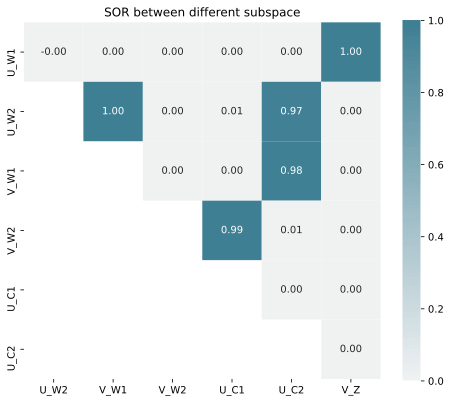

In [33]:
plt.subplots(figsize=(8,8))
mask = np.zeros_like(sor_between, dtype=bool)
mask[np.tril_indices_from(mask)] = True
sor_between = sor_between[:-1, 1:]
mask = mask[:-1, 1:]
ax = sns.heatmap(sor_between, mask=mask, vmin=0, vmax=1, center=0, annot=True, fmt='.2f', cmap=sns.diverging_palette(20, 220, n=200), square=True, cbar=True,cbar_kws={"shrink": 0.83})
ax.set_xticklabels(sor_label[1:])
ax.set_yticklabels(sor_label[:-1])
ax.set_title("SOR between different subspace")
plt.savefig(figure_path / "sor_decoder.png", dpi=600)

In [34]:
rank_state_r2[0].shape

torch.Size([4, 4096])

In [36]:
rank_state_marginal = vector()

rank_state_marginal = vector.meshgrid(T_r2, 2).reshape(T_r2,2)\
.rmap(lambda rank, rank_item: torch.stack([rank_state_r2[rank][ground_truth_r2[:, rank_item]==item].mean(0) for item in range(2)]), split_tuple=True)

In [37]:
rank1_subspace = torch.pca_lowrank(rank_state_marginal[-1, 0])[-1][:, :1]
rank2_subspace = torch.pca_lowrank(rank_state_marginal[-1, 1])[-1][:, :1]

In [38]:
print(vector(U_J1, U_J2, U_J3).map(lambda x: SOR(rank1_subspace, x)))
print(vector(U_J1, U_J2, U_J3).map(lambda x: SOR(rank2_subspace, x)))

[0.7570370129302725, 0.014077928101667391, 0.22884767009643672]
[0.15405148614066674, 0.8141795175289532, 0.03174297144925254]


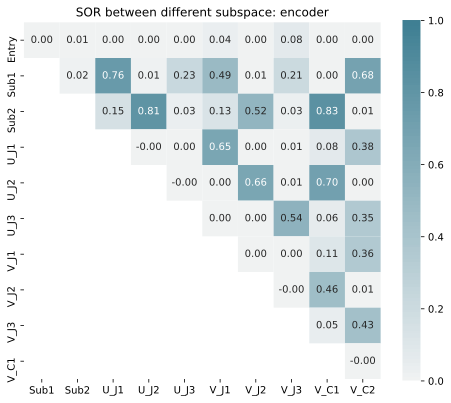

In [39]:
sor_candidate = vector(U_E, rank1_subspace, rank2_subspace, U_J1, U_J2, U_J3, V_J1, V_J2, V_J3, V_C[:, :1], V_C[:, 1:2])
sor_label = vector("Entry", "Sub1", "Sub2", "U_J1", "U_J2", "U_J3", "V_J1", "V_J2", "V_J3", "V_C1", "V_C2")
sor_between = vector.product(sor_candidate, sor_candidate).rmap(lambda x, y: SOR(x, y))
plt.subplots(figsize=(8,8))
mask = np.zeros_like(sor_between, dtype=bool)
mask[np.tril_indices_from(mask)] = True
sor_between = sor_between[:-1, 1:]
mask = mask[:-1, 1:]
ax = sns.heatmap(sor_between, mask=mask, vmin=0, vmax=1, center=0, annot=True, fmt='.2f', cmap=sns.diverging_palette(20, 220, n=200), square=True, cbar=True,cbar_kws={"shrink": 0.83})
ax.set_xticklabels(sor_label[1:])
ax.set_yticklabels(sor_label[:-1])
ax.set_title("SOR between different subspace: encoder")
plt.savefig(figure_path / "sor_encoder.png", dpi=600)

In [40]:
U_J_L1 = U_J1 * (S_J1 ** 0.5)
U_J_L2 = U_J2 * (S_J2 ** 0.5)
U_J_L3 = U_J3 * (S_J3 ** 0.5)
V_J_L1 = V_J1 * (S_J1 ** 0.5)
V_J_L2 = V_J2 * (S_J2 ** 0.5)
V_J_L3 = V_J3 * (S_J3 ** 0.5)
I = model.encoder.embedding.T[:, :1]
LoadingVector = vector(U_J_L1, U_J_L2, U_J_L3, V_J_L1, V_J_L2, V_J_L3, I).map(lambda x: x.detach().cpu().numpy())

In [387]:
plt.subplots(figsize=(60, 60))

for i in range(6):
    for j in range(i+1, 7):
        ax = plt.subplot(6, 6, i*6+j)
        plt.scatter(LoadingVector[i], LoadingVector[j], c='b', s=1)
        # plt.plot(LoadingVector[i], LoadingVector[j], '.b', lw=0.1)

plt.savefig(figure_path / "loading space.png", dpi=200)

<IPython.core.display.Javascript object>

In [41]:
((hidden_state.view(-1, 4096) @ U_J_L2) / (U_J_L2.T @ U_J_L2)).max()

RuntimeError: view size is not compatible with input tensor's size and stride (at least one dimension spans across two contiguous subspaces). Use .reshape(...) instead.

In [151]:
def vector_flow(k1, k2, L1=U_J_L1, L2=U_J_L2, U1=U_J_L1, U2=U_J_L2, U3=U_J_L3, V1=V_J_L1, V2=V_J_L2, V3=V_J_L3):
    if isinstance(k1, (float, int, np.float32)):
        with torch.no_grad():
            N = len(U1)
            x = k1 * L1 + k2 * L2
            U = torch.cat([U1, U2, U3], 1)
            V = torch.cat([V1, V2, V3], 1)
            v = -x + 1/N * (U @ (V.T @ torch.tanh(x)))
            return v, (v.T @ L1) / (L1.T @ L1), (v.T @ L2) / (L2.T @ L2)
    else:
        with torch.no_grad():
            k1 = k1.unsqueeze(-1)
            k2 = k2.unsqueeze(-1)
            x = k1 @ U1.T + k2 @ U2.T
            

In [118]:
x = fix_x[0] * U_J_L1 + fix_y[0] * U_J_L2

In [128]:
(x.T - model.encoder.rnn(x.T, torch.zeros_like(x.T)))

tensor([[-20.4401]], device='cuda:0', grad_fn=<MmBackward>)

In [117]:
vector_flow(fix_x[0], fix_y[0])

(tensor([[-0.0235],
         [-0.0112],
         [-0.0091],
         ...,
         [-0.0062],
         [-0.0055],
         [ 0.0084]], device='cuda:0'),
 tensor([[0.0096]], device='cuda:0'),
 tensor([[0.0139]], device='cuda:0'))

In [43]:
torch.cat([U_J_L1, U_J_L2], 1).shape

torch.Size([4096, 2])

In [152]:
k_vector = vector.meshgrid(vector.linspace(-1, 1, 100), vector.linspace(-1, 1, 100)).reshape(100, 100)
k_vector_flow = k_vector.rmap(lambda k1, k2: vector_flow(k1, k2))

In [153]:
k1, k2 = k_vector.rzip_split()
v, k1_v, k2_v = k_vector_flow.rzip_split()

In [154]:
k1_v = k1_v.rmap(float)
k2_v = k2_v.rmap(float)

In [155]:
print((rank_state_r2[-1] @ U_J_L1) / (U_J_L1.T @ U_J_L1))
print((rank_state_r2[-1] @ U_J_L2) / (U_J_L2.T @ U_J_L2))
qx = (rank_state_r2[-1] @ U_J_L1) / (U_J_L1.T @ U_J_L1)
qy = (rank_state_r2[-1] @ U_J_L2) / (U_J_L2.T @ U_J_L2)
qx = qx.detach().cpu().numpy()
qy = qy.detach().cpu().numpy()

tensor([[ 0.3678],
        [ 0.6577],
        [-0.6577],
        [-0.3678]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[ 0.4445],
        [-0.2903],
        [ 0.2903],
        [-0.4445]], device='cuda:0', grad_fn=<DivBackward0>)


In [156]:
k1_h = (hidden_state_r2 @ U_J_L1) / (U_J_L1.T @ U_J_L1)
k2_h = (hidden_state_r2 @ U_J_L2) / (U_J_L2.T @ U_J_L2)
k1_h_r2 = k1_h.squeeze().detach().cpu().numpy()
k2_h_r2 = k2_h.squeeze().detach().cpu().numpy() 

In [157]:
k1_v_norm = k1_v / (k1_v.numpy() ** 2 + k2_v.numpy() ** 2) ** 0.5
k2_v_norm = k2_v / (k1_v.numpy() ** 2 + k2_v.numpy() ** 2) ** 0.5

In [158]:
k1_v_norm.flatten()

array([ 0.81314967,  0.82058958,  0.8279125 , ..., -0.8279125 ,
       -0.82058958, -0.81314967])

In [159]:
k1_h_r1 = (hidden_state_r1 @ U_J_L1) / (U_J_L1.T @ U_J_L1)
k2_h_r1 = (hidden_state_r1 @ U_J_L2) / (U_J_L2.T @ U_J_L2)
k1_h_r1 = k1_h_r1.squeeze().detach().cpu().numpy()
k2_h_r1 = k2_h_r1.squeeze().detach().cpu().numpy()

In [160]:
def project(x, u1, u2):
    x = x.squeeze()
    u1 = u1.squeeze()
    u2 = u2.squeeze()
    return torch.tensor([torch.dot(x, u1) / torch.dot(u1, u1), torch.dot(x, u2)/torch.dot(u2, u2)])
V_W1_P = project(model.decoder.input_to_decoder @ V_W1, U_J_L1, U_J_L2)
V_W2_P = project(model.decoder.input_to_decoder @ V_W2, U_J_L1, U_J_L2)
V_W1_P = V_W1_P / max(V_W1_P)
V_W2_P = V_W2_P / max(V_W2_P)

In [161]:
U_J_L1.shape

torch.Size([4096, 1])

In [332]:
start_point = torch.tensor([[0.001, 0], [-0.001,0], [0, 0.001], [0, -0.001], [1, 0], [-1, 0], [0, 1], [0, -1], [-1, -0.25], [-1, -0.245], [1, 0.25], [1, 0.245], [-0.7, -0.7], [0.7, 0.7]], device=U_J_L1.device) 

In [333]:
(start_point @ torch.cat([U_J_L1, U_J_L2], dim=1).T).shape

torch.Size([14, 4096])

In [334]:
TT = 200
batch_size = start_point.shape[0] 
x = torch.zeros(TT, batch_size, 4096, device=start_point.device)
x[0, :, :] = start_point @ torch.cat([U_J_L1, U_J_L2], dim=1).T
for index in range(1, TT):
    x[index, :, :] = model.encoder.rnn(x[index-1, :, :], torch.zeros_like(x[index-1, :, :]))
x_p, y_p = (x @ U_J_L1) / torch.dot(U_J_L1.squeeze(), U_J_L1.squeeze()), (x @ U_J_L2) / torch.dot(U_J_L2.squeeze(), U_J_L2.squeeze())
xs = x_p.squeeze().detach().cpu().numpy()
ys = y_p.squeeze().detach().cpu().numpy()

In [335]:
x_p[-1, 0, :], y_p[-1, 0, :]

(tensor([0.7096], device='cuda:0', grad_fn=<SliceBackward>),
 tensor([-0.3720], device='cuda:0', grad_fn=<SliceBackward>))

In [336]:
fix_x[0], fix_y[0]

(0.70959276, -0.37201437)

In [337]:
((x[-1, 0, :] @ U_J_L1) / (U_J_L1.T @ U_J_L1)).squeeze() * U_J_L1

tensor([[-1.1730],
        [ 1.3624],
        [-0.8614],
        ...,
        [ 0.6243],
        [-0.0229],
        [-0.7096]], device='cuda:0', grad_fn=<MulBackward0>)

In [338]:
x[-1, 0, :].T - (fix_x[0] * U_J_L1 + fix_y[0] * U_J_L2)

tensor([[-0.1300,  3.0235, -0.0659,  ...,  1.7998,  0.9152,  0.2042],
        [-3.2587, -0.1051, -3.1946,  ..., -1.3289, -2.2134, -2.9244],
        [-0.1690,  2.9845, -0.1049,  ...,  1.7608,  0.8762,  0.1652],
        ...,
        [-2.1177,  1.0358, -2.0536,  ..., -0.1879, -1.0725, -1.7835],
        [-1.2157,  1.9379, -1.1516,  ...,  0.7141, -0.1704, -0.8814],
        [ 0.0916,  3.2452,  0.1557,  ...,  2.0214,  1.1369,  0.4259]],
       device='cuda:0', grad_fn=<SubBackward0>)

In [339]:
xs[-1, :]

array([ 0.70959276, -0.70959276, -0.709632  ,  0.709632  ,  0.7096634 ,
       -0.7096634 , -0.7096631 ,  0.7096631 , -0.1951317 , -0.70774955,
        0.1951317 ,  0.70774955,  0.00478738, -0.00478738], dtype=float32)

In [340]:
start_point = [0.001, 0], [-0.001,0], [0, 0.001]
fix_x = xs[-1, :2]
fix_y = ys[-1, :2]

In [341]:
fix_x, fix_y

(array([ 0.70959276, -0.70959276], dtype=float32),
 array([-0.37201437,  0.37201437], dtype=float32))

In [342]:
I.shape

(100, 100)

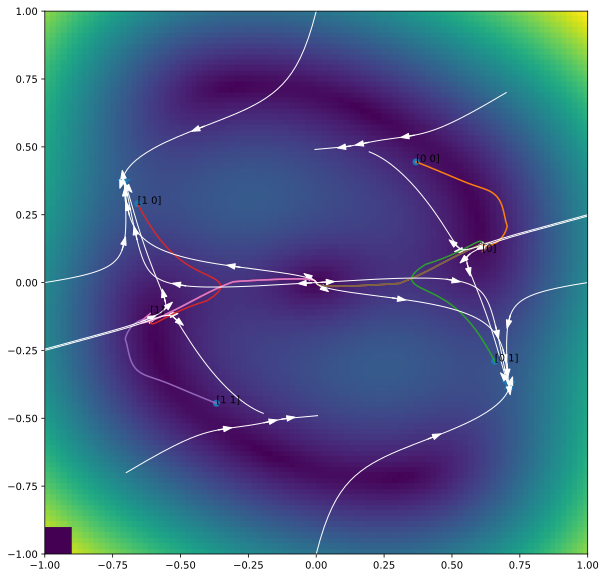

In [343]:
plt.subplots(figsize=(10,10))

I = (k1_v.numpy() ** 2 + k2_v.numpy() ** 2) ** 0.5
I[:5, :5] = 0
plt.imshow(np.flip(I, axis=0), extent=[-1, 1, -1, 1])

# plt.quiver(k1.flatten().numpy(), k2.flatten().numpy(), k1_v_norm.flatten(), k2_v_norm.flatten())
plt.plot(qx, qy, "o")


for i in range(4):
    plt.plot(k1_h_r2[i], k2_h_r2[i])
    plt.text(k1_h_r2[i][-1], k2_h_r2[i][-1], str(ground_truth_r2[i]))

for j in range(2):
    plt.plot(k1_h_r1[j], k2_h_r1[j])
    plt.text(k1_h_r1[j][-1], k2_h_r1[j][-1], str(ground_truth_r1[j]))
    
for batch in range(xs.shape[1]):
    x = xs[:, batch]
    y = ys[:, batch]
    plt.plot(x, y, "w", lw=1.0)
    for i in [20, 50, 80]:
        d = 5
        dx = x[i+d]-x[i]
        dy = y[i+d]-y[i]
        dnorm = (dx ** 2 + dy ** 2) ** 0.5
        dx, dy = dx / dnorm, dy / dnorm
        plt.arrow(x[i], y[i], dx*0.02, dy*0.02, color="w", head_width=0.02, length_includes_head=False)

plt.scatter(fix_x, fix_y, marker="*", s=200)

# plt.plot([V_W1_P[0], -V_W1_P[0]], [V_W1_P[1], -V_W1_P[1]], "-.k")
# plt.plot([V_W2_P[0], -V_W2_P[0]], [V_W2_P[1], -V_W2_P[1]], "-.c")

plt.savefig(figure_path / "vector field.png", dpi=600)

In [365]:
k1_h = (hidden_state_r2 @ U_J_L1) / (U_J_L1.T @ U_J_L1)
k2_h = (hidden_state_r2 @ U_J_L2) / (U_J_L2.T @ U_J_L2)
k3_h = (hidden_state_r2 @ U_J_L3) / (U_J_L3.T @ U_J_L3)
k1_h_r2 = k1_h.squeeze().detach().cpu().numpy()
k2_h_r2 = k2_h.squeeze().detach().cpu().numpy() 
k3_h_r2 = k3_h.squeeze().detach().cpu().numpy()

k1_h_r1 = (hidden_state_r1 @ U_J_L1) / (U_J_L1.T @ U_J_L1)
k2_h_r1 = (hidden_state_r1 @ U_J_L2) / (U_J_L2.T @ U_J_L2)
k3_h_r1 = (hidden_state_r1 @ U_J_L3) / (U_J_L3.T @ U_J_L3)
k1_h_r1 = k1_h_r1.squeeze().detach().cpu().numpy()
k2_h_r1 = k2_h_r1.squeeze().detach().cpu().numpy()
k3_h_r1 = k3_h_r1.squeeze().detach().cpu().numpy()

k1_h_r3 = (hidden_state_r3 @ U_J_L1) / (U_J_L1.T @ U_J_L1)
k2_h_r3 = (hidden_state_r3 @ U_J_L2) / (U_J_L2.T @ U_J_L2)
k3_h_r3 = (hidden_state_r3 @ U_J_L3) / (U_J_L3.T @ U_J_L3)
k1_h_r3 = k1_h_r3.squeeze().detach().cpu().numpy()
k2_h_r3 = k2_h_r3.squeeze().detach().cpu().numpy()
k3_h_r3 = k3_h_r3.squeeze().detach().cpu().numpy()

In [377]:
start_point = torch.tensor([[0.001, 0, 0],
                            [-0.001,0, 0],
                            [0, 0.001, 0],
                            [0, -0.001, 0],
                            [1, 0, 0],
                            [-1, 0, 0],
                            [0, 1, 0], [0, -1, 0],
                            [-1, -0.25, 0], [-1, -0.245, 0], [1, 0.25, 0], [1, 0.245, 0],
                            [-0.7, -0.7, 0], [0.7, 0.7, 0],
                           ], device=U_J_L1.device) 

TT = 300
batch_size = start_point.shape[0] 
x = torch.zeros(TT, batch_size, 4096, device=start_point.device)
x[0, :, :] = start_point @ torch.cat([U_J_L1, U_J_L2, U_J_L3], dim=1).T
for index in range(1, TT):
    x[index, :, :] = model.encoder.rnn(x[index-1, :, :], torch.zeros_like(x[index-1, :, :]))
x_p, y_p, z_p = (x @ U_J_L1) / torch.dot(U_J_L1.squeeze(), U_J_L1.squeeze()), (x @ U_J_L2) / torch.dot(U_J_L2.squeeze(), U_J_L2.squeeze()), (x @ U_J_L3) / torch.dot(U_J_L3.squeeze(), U_J_L3.squeeze())
xs = x_p.squeeze().detach().cpu().numpy()
ys = y_p.squeeze().detach().cpu().numpy()
zs = z_p.squeeze().detach().cpu().numpy()

<IPython.core.display.Javascript object>


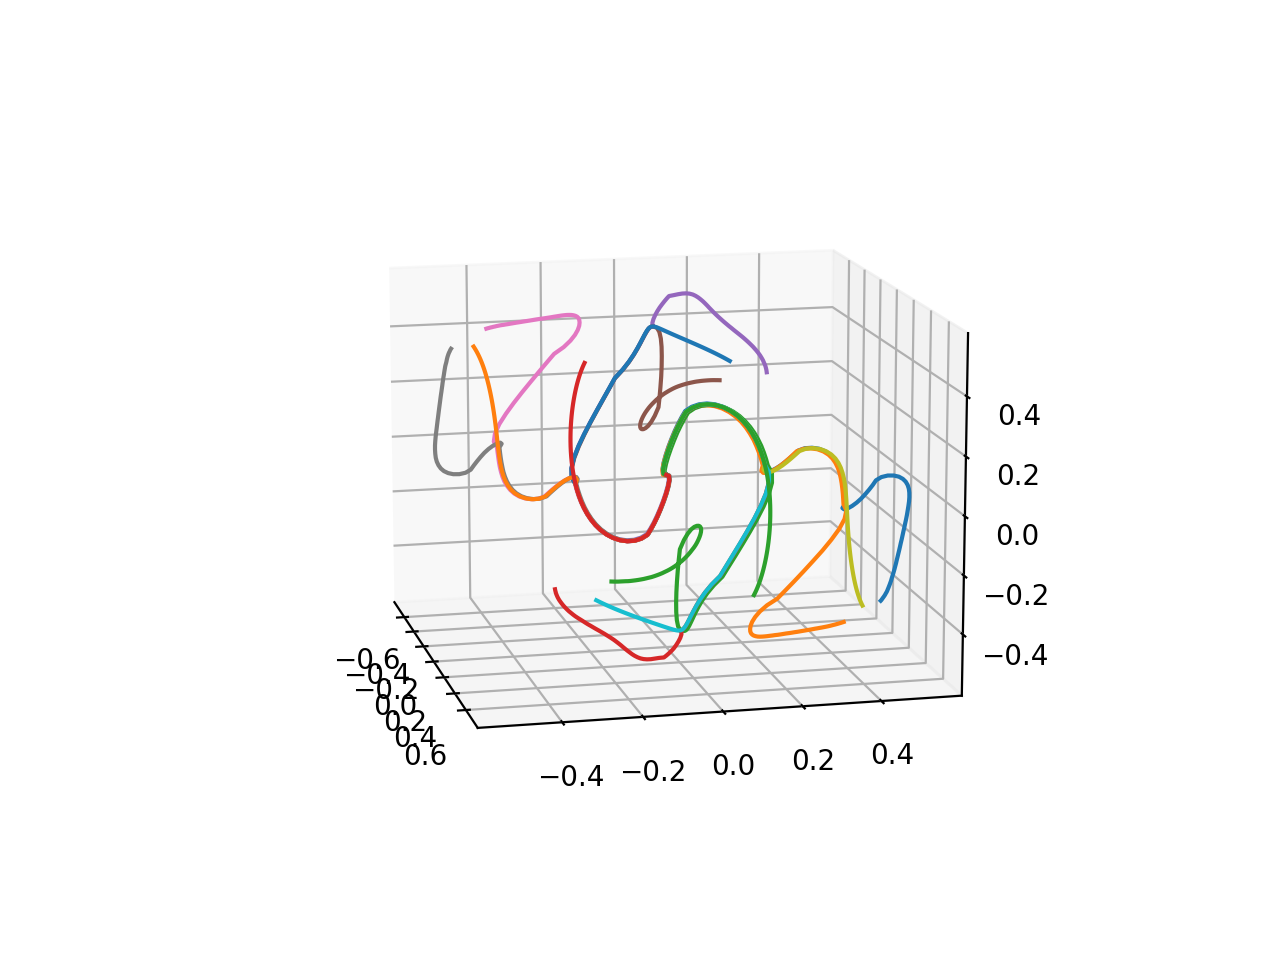

In [386]:
%matplotlib notebook

ax = plt.axes(projection='3d')

for i in range(8):
    ax.plot3D(k1_h_r3[i, :], k2_h_r3[i, :], k3_h_r3[i, :])

for i in range(4):
    ax.plot3D(k1_h_r2[i, :], k2_h_r2[i, :], k3_h_r2[i, :])
    
for i in range(2):
    ax.plot3D(k1_h_r1[i, :], k2_h_r1[i, :], k3_h_r1[i, :])    
    
# for batch in range(xs.shape[1]):
#     x = xs[:, batch]
#     y = ys[:, batch]
#     z = zs[:, batch]
#     ax.plot3D(x, y, z, lw=0.8)

In [352]:
k3_h_r2.shape

(4, 101)

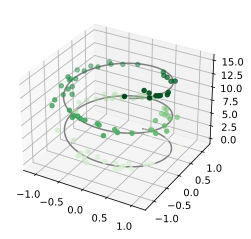

In [351]:
ax = plt.axes(projection='3d')

# Data for a three-dimensional line
zline = np.linspace(0, 15, 1000)
xline = np.sin(zline)
yline = np.cos(zline)
ax.plot3D(xline, yline, zline, 'gray')

# Data for three-dimensional scattered points
zdata = 15 * np.random.random(100)
xdata = np.sin(zdata) + 0.1 * np.random.randn(100)
ydata = np.cos(zdata) + 0.1 * np.random.randn(100)
ax.scatter3D(xdata, ydata, zdata, c=zdata, cmap='Greens');

In [ ]:
V_W1_P

In [ ]:
k1_h[i][-1], k2_h[i][-1], "hello", "b"

In [ ]:
ground_truth

In [ ]:
rank_state_mean = rank_state.map(lambda x: x.mean(0))
U, S, V = torch.pca_lowrank(torch.stack(rank_state_mean))

In [ ]:
torch.stack(rank_state_mean).abs().sum(-1)

In [ ]:
delay = [15, 15, 15, 50]
rank = [10, 10, 10]
t = 0
for i in range(3):
    t += delay[i]
    b = t
    t += rank[i]
    print(b+1, t)

In [ ]:
torch.eye(2)

In [ ]:
def normalized_2d_circle(x, another_index=1, return_transform_matrix=False):
    if not isinstance(x, torch.Tensor):
        x = torch.tensor(x)
    transform_matrix = torch.eye(2, device=x.device)
    if x[0, 0] == 0:
        if x[0, 1] == 0:
            if return_transform_matrix:
                return x, transform_matrix
            else:
                return x
        else:
            if return_transform_matrix:
                ans, next_transform = nomalized_2d_circle(x @ torch.tensor([[0, 1.0], [-1.0, 0]]).to(x.device), return_transform_matrix=True)
                return ans, torch.tensor([[0, 1.0], [-1.0, 0]]).to(x.device) @ next_transform
            else:
                return nomalized_2d_circle(x @ torch.tensor([[0, 1.0], [-1.0, 0]]).to(x.device))
    if x[0, 0] < 0:
        x = x @ torch.tensor([[- 1.0, 0], [0, 1.0]]).to(x.device)
        transform_matrix = torch.tensor([[- 1.0, 0], [0, 1.0]]).to(x.device)
    alpha = torch.arctan(x[0, 1] / x[0, 0])
    A = torch.tensor([[torch.cos(alpha), -torch.sin(alpha)], [torch.sin(alpha), torch.cos(alpha)]]).to(x.device)
    ret = x @ A
    transform_matrix = transform_matrix @ A
    if ret[another_index, 1] < 0:
        ret = ret @ torch.tensor([[1.0, 0], [0, -1.0]]).to(ret.device)
        transform_matrix = transform_matrix @ torch.tensor([[1.0, 0], [0, -1.0]]).to(ret.device)
    if return_transform_matrix:
        return ret, transform_matrix
    else:
        return ret

def get_title(frame):
    if frame > 75:
        return "last dealy"
    if frame > 65:
        return "rank3"
    if frame > 50:
        return "delay2"
    if frame > 40:
        return "rank2"
    if frame > 25:
        return "delay1"
    if frame > 15:
        return "rank1"
    return "delay0"

def get_mean_variance(x):
    assert isinstance(x, torch.Tensor) and len(x.shape) == 2
    x = x - x.mean(0).unsqueeze(0)
    return torch.square(x).sum(-1).mean().item()

In [ ]:
U, S, V = rank_state.map(lambda rs: torch.pca_lowrank(rs, q=64)).zip_split()

point = vector.zip(rank_state, V).map(lambda rs, v: (rs @ v[:, :2]).cpu().numpy(), split_tuple=True).map(lambda x: normalized_2d_circle(x, 36))

# U1, S1, V1 = torch.pca_lowrank(rank1_state)
# point1 = (rank1_state @ V1[:, :2]).cpu().numpy()

# U2, S2, V2 = torch.pca_lowrank(rank2_state)
# point2 = (rank2_state @ V2[:, :2]).cpu().numpy()

# U3, S3, V3 = torch.pca_lowrank(rank3_state)
# point3 = (rank3_state @ V3[:, :2]).cpu().numpy()

In [ ]:
t = rank_state.map_async(lambda rs: torch.pca_lowrank(rs, q=64))

In [ ]:
t[0].get()

In [ ]:
vector.zip(rank_state, V).map(lambda rs, v: (rs @ v[:, :2]).cpu().numpy(), split_tuple=True).element_type

In [ ]:
print(rank_state.shape, rank_state[0].shape)
print(point.shape, point.element_type, point[0].shape)

In [ ]:
%matplotlib inline
time=25

for tr in range(3):
    plt.subplot(2, 2, tr+1)
    plt.axis('equal')
    for item in range(6):
        plt.plot(point[time-1][ground_truth[:, tr] == item, 0], point[time-1][ground_truth[:, tr] == item, 1], ".", alpha=0.2)

plt.show()

In [ ]:
%matplotlib inline
time=50

for tr in range(3):
    plt.subplot(2, 2, tr+1)
    plt.axis('equal')
    for item in range(6):
        plt.plot(point[time-1][ground_truth[:, tr] == item, 0], point[time-1][ground_truth[:, tr] == item, 1], ".", alpha=0.2)

plt.show()

In [ ]:
%matplotlib inline
time=75

for tr in range(3):
    plt.subplot(2, 2, tr+1)
    plt.axis('equal')
    for item in range(6):
        plt.plot(point[time-1][ground_truth[:, tr] == item, 0], point[time-1][ground_truth[:, tr] == item, 1], ".", alpha=0.2)

plt.show()

In [ ]:
pc2_variance = point.map(get_mean_variance)
total_variance = rank_state.map(get_mean_variance)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib import animation

%matplotlib notebook

fig, ax = plt.subplots(figsize=(8, 8), tight_layout=True)
ttl = fig.suptitle("PCA")

sa_vector = vector()

width = 25

for rank_colored in range(3):

    ax = plt.subplot(2, 2, rank_colored+1)

    sa = ScatterAnimation(ax, T)
    sa.set_xlim(-width, width)
    sa.set_ylim(-width, width)
    
    for item in range(6):
        sa.register(torch.stack(point.map(lambda x: x[ground_truth[:, rank_colored] == item, :])))
    
    sa.set_titlefunc("colored by rank {}".format(rank_colored+1))
    
    sa_vector.append(sa)

ax = plt.subplot(2, 2, 4)

ts = TimeStamp(ax, T)
ts.register(total_variance, label="total_variance")
ts.register(pc2_variance, label="pc2_variance")
ts.set_xticks([15, 25, 40, 50, 65, 75, 125], ["r1", "d1", "r2", "d2", "r3", "ld", "end_ld"])

def init():
    ret = functools.reduce(lambda x, y: x+y, sa_vector.map(lambda x: x.init()).append(ts.init()))
    return ret

def update(frame):
    ret = functools.reduce(lambda x, y: x+y, sa_vector.map(lambda x: x.update(frame)).append(ts.update(frame)))    
    ttl.set_text("PCA @ {}({})".format(frame, get_title(frame)))
    return ret + tuple([ttl])


ani = FuncAnimation(fig, update, frames=np.arange(T),
                    init_func=init, blit=True)
# plt.show()
# Writer = animation.writers['ffmpeg']
# writer = Writer(fps=5, metadata=dict(artist='Me'), bitrate=18000)

ani.save(media_path / f'PCA colored by different rank.mp4', writer="ffmpeg", fps=5, dpi=600)

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# from matplotlib.animation import FuncAnimation
# from matplotlib import animation

# %matplotlib notebook

# fig, ax = plt.subplots(figsize=(8, 8), tight_layout=True)
# # lnn_vector = vector()

# fig.suptitle("PCA")

# sa_vector = vector()

# for rank_colored in range(3):

#     s_ax = plt.subplot(2, 2, rank_colored+1)
#     ax_vector.append(s_ax)
#     sa = ScatterAnimation(s_ax, 126)
#     for item in range(6):
#         sa.register(torch.stack(point.map(lambda x: x[ground_truth[:, rank_colored] == item, :])))
#     sa_vector.append(sa)

# ax_t = plt.subplot(2, 2, 4)

# ts = TimeStamp(ax_t, 126)
# ts.register(total_variance)
# ts.register(pc2_variance)

# def init():
#     for rank in range(3):
#         ax_vector[rank].set_xlim(-25, 25)
#         ax_vector[rank].set_ylim(-25, 25)
#     return sa_vector.
# #     return tuple(lnn_vector.flatten())

# def update(frame):
#     for rank_colored in range(3):
#         for item in range(6):
#             xdata = point[frame][ground_truth[:, rank_colored] == item, 0]
#             ydata = point[frame][ground_truth[:, rank_colored] == item, 1]
#             lnn_vector[rank_colored][item].set_data(xdata, ydata)
#     two_dot.set_offsets([[frame, total_variance[frame]], [frame, pc2_variance[frame]]])
#     line.set_data([frame, frame], [0, total_variance[frame]])
#     ttl.set_text("PCA @ {}({})".format(frame, get_title(frame)))
#     return tuple(lns) + tuple([two_dot, line])

# ani = FuncAnimation(fig, update, frames=np.arange(126),
#                     init_func=init, blit=True)
# # plt.show()
# # Writer = animation.writers['ffmpeg']
# # writer = Writer(fps=5, metadata=dict(artist='Me'), bitrate=18000)

# ani.save(f'PCA colored by different rank.mp4', writer="ffmpeg", fps=5, dpi=600)





In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# from matplotlib.animation import FuncAnimation
# from matplotlib import animation

# %matplotlib notebook

# fig, ax = plt.subplots(tight_layout=True)
# xdata, ydata = [], []
# lns = vector()
# for i in range(6):
#     ln, = plt.plot([], [], 'o')
#     lns.append(ln)

# rank_colored = 3

# ttl = ax.set_title(f"PCA colored by rank{rank_colored}")


# def init():
#     ax.set_xlim(-25, 25)
#     ax.set_ylim(-25, 25)
#     return tuple(lns)

# def update(frame):
#     for item in range(6):
#         xdata = point[frame][ground_truth[:, rank_colored-1] == item, 0]
#         ydata = point[frame][ground_truth[:, rank_colored-1] == item, 1]
#         lns[item].set_data(xdata, ydata)
#     ttl.set_text("PCA @ {} colored by items at rank{}({})".format(frame, rank_colored, get_title(frame)))
#     return tuple(lns)

# ani = FuncAnimation(fig, update, frames=np.arange(126),
#                     init_func=init, blit=True)
# # plt.show()
# # Writer = animation.writers['ffmpeg']
# # writer = Writer(fps=5, metadata=dict(artist='Me'), bitrate=18000)

# ani.save(f'PCA colored by rank{rank_colored}.mp4', writer="ffmpeg", fps=5, dpi=600)




In [ ]:
rank_state_marginal = vector()

rank_state_marginal = vector.meshgrid(T, 3).reshape(T,3)\
.rmap(lambda rank, rank_item: torch.stack([rank_state[rank][ground_truth[:, rank_item]==item].mean(0) for item in range(6)]), split_tuple=True)


In [ ]:
rank_state_marginal[0, 0]

In [ ]:
entry_space = vector.range(3).map(lambda rank: torch.pca_lowrank(rank_state_marginal[25 * (rank+1), rank])[2][:, :2])

In [ ]:
U_marginal, S_marginal, V_marginal = rank_state_marginal.rmap(lambda rs: torch.pca_lowrank(rs, q=6)).rzip_split()

point_marginal = vector.rzip(rank_state_marginal, V_marginal).rmap(lambda rs, v: (rs @ v[:, :2]).cpu().numpy(), split_tuple=True).rmap(lambda p: normalized_2d_circle(p))

subspace = V_marginal[125].map(lambda v: v[:, :2])
print(subspace.shape, subspace[0].shape)

In [ ]:
entry_space.map(lambda es: SOR(input_space, es))

In [ ]:
def subspace_project_remain(x, *subspaces):
    for subspace in subspaces:
        x = x - subspace @ subspace.T @ x
    return x

In [ ]:
entry_space[0].shape, subspace[2].shape

In [ ]:
# Variance left for entry space after projected onto subspace 3 and input space

entry_space.map(lambda x: subspace_project_remain(x, *subspace, input_space)).map(lambda x: torch.trace(x.T @ x) / 2)

In [ ]:
1

In [ ]:
U_readout, S_readout, V_readout = torch.pca_lowrank(model.decoder.linear_layer.weight)

In [ ]:
print(get_shape(U_readout))
print(get_shape(V_readout))

In [ ]:
V_marginal[125].map(lambda v: SOR(input_space, v[:,:2]))

In [ ]:
subspace.map(lambda x: SOR(x, input_space))

In [ ]:
print(V_marginal.shape, V_marginal[0, 0].shape)
print(point_marginal.shape, point_marginal[0, 0].shape)
print(rank_state_marginal.shape, rank_state_marginal[0, 0].shape)

In [ ]:
rank_pc2_variance = vector.range(3).map(lambda rank: vector.range(T).map(lambda index: get_mean_variance(point_marginal[index, rank])))
rank_total_variance = vector.range(3).map(lambda rank: vector.range(T).map(lambda index: get_mean_variance(rank_state_marginal[index, rank])))

In [ ]:
model.decoder.linear_layer.bias

In [ ]:
consider_space = vector(input_space, *entry_space, *subspace)

In [ ]:
consider_space.map(lambda x: x.shape)

In [ ]:
%matplotlib inline

sor_between = vector.meshrange(7, 7).rmap(lambda ix, iy: SOR(consider_space[ix], consider_space[iy]))
plt.subplots(figsize=(8,8))
ax = sns.heatmap(sor_between, vmin=0, vmax=1, center=0, annot=True, fmt='.2f', cmap=sns.diverging_palette(20, 220, n=200), square=True, cbar=True,cbar_kws={"shrink": 0.83})
ax.set_xticklabels(["input", "entry1", "entry2", "entry3", "sub1", "sub2", "sub3"])
ax.set_yticklabels(["input", "entry1", "entry2", "entry3", "sub1", "sub2", "sub3"])
ax.set_title("SOR between different subspace")

plt.savefig(figure_path / "SOR between different subspace.png", dpi=600)

In [ ]:
U_W.shape, S_W.shape, V_W.shape

In [ ]:
U_W[:, :6], V_W[:, :6]

In [ ]:
S_W[:6]

In [ ]:
print(SOR(U_W[:, :6], V_W[:, :6]))
print(torch.trace(U_W[:, :6] @ U_W[:, :6].T))

In [ ]:
%matplotlib inline

sor_W = vector.meshrange(6,6).rmap(lambda ix, iy: SOR(U_W[:, ix:ix+1], V_W[:, iy:iy+1]))

plt.subplots(figsize=(8,8))
ax = sns.heatmap(sor_W, vmin=0, vmax=1, center=0, annot=True, fmt='.2f', cmap=sns.diverging_palette(20, 220, n=200), square=True, cbar=True,cbar_kws={"shrink": 0.83})
ax.set_yticklabels(["U_W{}".format(index+1) for index in range(6)])
ax.set_xticklabels(["V_W{}".format(index+1) for index in range(6)])
ax.set_title("SOR between left and right principle vector for W")

plt.savefig(figure_path / "SOR between left and right principle vector for W.png", dpi=600)

In [ ]:
%matplotlib inline

sor_W = vector.meshrange(3,3).rmap(lambda ix, iy: SOR(U_W[:, (2*ix):(2*ix+2)], V_W[:, (2*iy):(2*iy+2)]))

plt.subplots(figsize=(8,8))
ax = sns.heatmap(sor_W, vmin=0, vmax=1, center=0, annot=True, fmt='.2f', cmap=sns.diverging_palette(20, 220, n=200), square=True, cbar=True,cbar_kws={"shrink": 0.83})
ax.set_yticklabels(["U_W{},{}".format(2*index+1, 2*index+2) for index in range(3)])
ax.set_xticklabels(["V_W{},{}".format(2*index+1, 2*index+2) for index in range(3)])
ax.set_title("SOR between left and right principle vector for W")

plt.savefig(figure_path / "SOR between left and right principle vector space for W.png", dpi=600)

In [ ]:
%matplotlib inline

considered_space_right = vector(V_W[:, :2], V_W[:, 2:4], V_W[:, 4:6], *subspace, V_readout[:, :2])
considered_space_left = vector(U_W[:, :2], U_W[:, 2:4], U_W[:, 4:6], *subspace, V_readout[:, :2])

sor = vector.product(considered_space_left, considered_space_right).rmap(lambda x, y: SOR(x, y))

plt.subplots(figsize=(8,8))

ax = sns.heatmap(sor, vmin=0, vmax=1, center=0, annot=True, fmt='.2f', cmap=sns.diverging_palette(20, 220, n=200), square=True, cbar=True,cbar_kws={"shrink": 0.83})
ax.set_yticklabels(["U_W{},{}".format(2*index+1, 2*index+2) for index in range(3)] + ["subs {}".format(rank) for rank in range(1, 4)] + ["readout"])
ax.set_xticklabels(["V_W{},{}".format(2*index+1, 2*index+2) for index in range(3)] + ["subs {}".format(rank) for rank in range(1, 4)] + ["readout"])
ax.set_title("SOR between different space")

plt.savefig(figure_path / "SOR explanation.png", dpi=600)

In [ ]:
for index in range(6):
    print(SOR(V_W[:, index:index+1], U_W[:, :6]))

In [ ]:
for index in range(6):
    print(SOR(U_W[:, index:index+1], V_W[:, :6]))

In [ ]:
SOR_with_inputspace = V_marginal.rmap(lambda vs: SOR(vs[:, :2], input_space))
SOR_with_subspace = vector.meshrange(3,3).rmap(lambda vm_rank, sub_rank: V_marginal[:, vm_rank].map(lambda v: SOR(v[:, :2], subspace[sub_rank])))

In [ ]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(8, 8), tight_layout=True)

marginal_space = 1

fig.suptitle("SOR of marginal subspace %d with different subspace" % marginal_space)

for rank in range(3):
    ax = plt.subplot(2,2,rank+1)
    ax.set_ylim(0, 1)
    ax.set_xticks([15, 25, 40, 50, 65, 75, 125])
    ax.set_xticklabels(["r1", "d1", "r2", "d2", "r3", "ld", "end_ld"])
    ax.set_title("subspace {}".format(rank+1))
    SOR_with_subspace[marginal_space-1, rank].plot(ax)
    
ax = plt.subplot(2,2,4)
ax.plot(range(T), point_marginal[:, marginal_space-1].map(get_mean_variance), "r", linewidth=1)
ax.plot(range(T), rank_state_marginal[:, marginal_space-1].map(get_mean_variance), "r", linewidth=0.3)
ax.legend(["pc2 variance", "total variance"])
ax.set_xticks([15, 25, 40, 50, 65, 75, 125])
ax.set_xticklabels(["r1", "d1", "r2", "d2", "r3", "ld", "end_ld"])
    
plt.savefig(figure_path / "SOR of marginal subspace %d with different subspace.png" % marginal_space, dpi=600)

In [ ]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(8, 8), tight_layout=True)

marginal_space = 2

fig.suptitle("SOR of marginal subspace %d with different subspace" % marginal_space)

for rank in range(3):
    ax = plt.subplot(2,2,rank+1)
    ax.set_ylim(0, 1)
    ax.set_xticks([15, 25, 40, 50, 65, 75, 125])
    ax.set_xticklabels(["r1", "d1", "r2", "d2", "r3", "ld", "end_ld"])
    ax.set_title("subspace {}".format(rank+1))
    SOR_with_subspace[marginal_space-1, rank].plot(ax)
    
ax = plt.subplot(2,2,4)
ax.plot(range(T), point_marginal[:, marginal_space-1].map(get_mean_variance), "r", linewidth=1)
ax.plot(range(T), rank_state_marginal[:, marginal_space-1].map(get_mean_variance), "r", linewidth=0.3)
ax.legend(["pc2 variance", "total variance"])
ax.set_xticks([15, 25, 40, 50, 65, 75, 125])
ax.set_xticklabels(["r1", "d1", "r2", "d2", "r3", "ld", "end_ld"])
    
plt.savefig(figure_path / "SOR of marginal subspace %d with different subspace.png" % marginal_space, dpi=600)

In [ ]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(8, 8), tight_layout=True)

marginal_space = 3

fig.suptitle("SOR of marginal subspace %d with different subspace" % marginal_space)

for rank in range(3):
    ax = plt.subplot(2,2,rank+1)
    ax.set_ylim(0, 1)
    ax.set_xticks([15, 25, 40, 50, 65, 75, 125])
    ax.set_xticklabels(["r1", "d1", "r2", "d2", "r3", "ld", "end_ld"])
    ax.set_title("subspace {}".format(rank+1))
    SOR_with_subspace[marginal_space-1, rank].plot(ax)
    
ax = plt.subplot(2,2,4)
ax.plot(range(T), point_marginal[:, marginal_space-1].map(get_mean_variance), "r", linewidth=1)
ax.plot(range(T), rank_state_marginal[:, marginal_space-1].map(get_mean_variance), "r", linewidth=0.3)
ax.legend(["pc2 variance", "total variance"])
ax.set_xticks([15, 25, 40, 50, 65, 75, 125])
ax.set_xticklabels(["r1", "d1", "r2", "d2", "r3", "ld", "end_ld"])
    
plt.savefig(figure_path / "SOR of marginal subspace %d with different subspace.png" % marginal_space, dpi=600)

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8), tight_layout=True)
fig.suptitle("SOR of marginal subspace with input space")
for rank in range(3):
    ax = plt.subplot(2, 2, rank+1)
    SOR_with_inputspace[:, rank].plot(ax)
    ax.set_title("rank {}".format(rank+1))
    ax.set_xticks([15, 25, 40, 50, 65, 75, 125])
    ax.set_xticklabels(["r1", "d1", "r2", "d2", "r3", "ld", "end_ld"])
plt.savefig(figure_path / "SOR of marginal subspace with input space.pdf", format="pdf")

In [ ]:
temp = vector.rzip(rank_state_marginal, V_marginal).rmap(lambda rs, v: (rs @ v[:, :2] @ v[:, :2].T))[125]
single_neuron_item_selective = vector.range(1024).map(lambda n: temp.map(lambda x: x[:, n]))

In [ ]:
point, transform_matrix = vector.zip_split(vector.rzip(rank_state_marginal, V_marginal)[125].map(lambda rs, v: (rs @ v[:, :2])).map(lambda x: normalized_2d_circle(x, return_transform_matrix=True)))

In [ ]:
projection_matrix = vector.zip(V_marginal[125], transform_matrix).map(lambda v, t: v[:, :2] @ t)

In [ ]:
vector.zip(rank_state_marginal[125], projection_matrix).map(lambda rs, p: rs @ p)

In [ ]:
get_shape(projection_matrix)

In [ ]:
def e(n, i, device=None):
    if device is not None:
        ret = torch.zeros(n).to(device)
    else:
        ret = torch.zeros(n)
    ret[i] = 1.0
    return ret

In [ ]:
math.atan(-1)

In [ ]:
def get_phi(x):
    if x[0] == 0:
        if x[1] >= 0:
            return math.pi / 2
        else:
            return -math.pi / 2
    elif x[1] == 0:
        if x[0] >= 0:
            return 0
        else:
            return math.pi
    else:
        t = math.atan(x[1]/x[0])
        if x[0] < 0:
            t += math.pi
        if t > math.pi:
            t -= math.pi * 2
        return t
        

In [ ]:
single_neuron_projection = vector.from_range(1024, lambda index: projection_matrix.map(lambda x: x[index]))

In [ ]:
single_neuron_phi = single_neuron_projection.rmap(get_phi)

In [ ]:
get_shape(single_neuron_phi)

In [ ]:
diff_phi12 = single_neuron_phi[:, :2].map(lambda x: abs(x[0]-x[1])).map(lambda x: min(x, 2*math.pi-x)).map(lambda x: x / math.pi * 180)
diff_phi13 = single_neuron_phi[:, [True, False, True]].map(lambda x: abs(x[0]-x[1])).map(lambda x: min(x, 2*math.pi-x)).map(lambda x: x / math.pi * 180)
diff_phi23 = single_neuron_phi[:, 1:].map(lambda x: abs(x[0]-x[1])).map(lambda x: min(x, 2*math.pi-x)).map(lambda x: x / math.pi * 180)

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
for index, name, diff in [(1, "|phi1-phi2|", diff_phi12), (2, "|phi1-phi3|", diff_phi23), (3, "|phi2-phi3|", diff_phi13)]:
    ax = plt.subplot(2, 2, index)
    diff.plot_hist(bins=6, ax=ax)
    ax.set_xticks([0,60,120,180])
    ax.set_xticklabels(vector([0,60,120,180]).map(str))
    ax.set_title(name)

In [ ]:
diff_phi13.plot_hist(bins=6)

In [ ]:
diff_phi23.plot_hist(bins=6)

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8), tight_layout=True)

for n in range(16):

    ax = plt.subplot(4,4,n+1)
    
    for rank in range(3):
        ax.plot(range(6), single_neuron_item_selective[n, rank].cpu())
    
    ax.set_ylim(-1, 1)
    
    ax.set_xticks(range(6))
    ax.set_xticklabels(vector.range(6).map(str))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib import animation

%matplotlib notebook

fig, ax = plt.subplots(figsize=(8, 8), tight_layout=True)
ttl = fig.suptitle("M-PCA for different rank items")

sa_vector = vector()

width = 25

for rank_colored in range(3):

    ax = plt.subplot(2, 2, rank_colored+1)

    sa = ScatterAnimation(ax, T)
    sa.set_xlim(-width, width)
    sa.set_ylim(-width, width)
    sa.set_titlefunc("rank {}".format(rank_colored+1))
    
    for item in range(6):
        # xdata = point_marginal[frame, rank_colored][item:item+1, 0]
        # ydata = point_marginal[frame, rank_colored][item:item+1, 1]
        sa.register(torch.stack(point_marginal.map(lambda x: x[rank_colored][item:item+1, :])))
        
    sa_vector.append(sa)

ax = plt.subplot(2, 2, 4)

ts = TimeStamp(ax, T)
for rank in range(3):
    color = ['r', 'b', 'c'][rank]
    ts.register(rank_pc2_variance[rank], label="rank {} pc2 variance".format(rank+1), color=color)
    ts.register(rank_total_variance[rank], color=color, linewidth=0.3)
    
ts.set_xticks([15, 25, 40, 50, 65, 75, 125], ["r1", "d1", "r2", "d2", "r3", "ld", "end_ld"])

def init():
    ret = functools.reduce(lambda x, y: x+y, sa_vector.map(lambda x: x.init()).append(ts.init()))
    return ret

def update(frame):
    ret = functools.reduce(lambda x, y: x+y, sa_vector.map(lambda x: x.update(frame)).append(ts.update(frame)))    
    ttl.set_text("M-PCA for different rank items @ {}({})".format(frame, get_title(frame)))
    return ret + tuple([ttl])


ani = FuncAnimation(fig, update, frames=np.arange(T),
                    init_func=init, blit=True)
# plt.show()
# Writer = animation.writers['ffmpeg']
# writer = Writer(fps=5, metadata=dict(artist='Me'), bitrate=18000)

ani.save(f'M-PCA for different rank items.mp4', writer="ffmpeg", fps=5, dpi=600)

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# from matplotlib.animation import FuncAnimation
# from matplotlib import animation

# %matplotlib notebook

# fig, ax = plt.subplots(figsize=(8, 8), tight_layout=True)
# lnn_vector = vector()

# ttl = fig.suptitle("M-PCA for different rank items")

# ax_vector = vector()

# for rank_colored in range(3):

#     s_ax = plt.subplot(2, 2, rank_colored+1)

#     xdata, ydata = [], []
#     lns = vector()
#     for i in range(6):
#         ln, = plt.plot([], [], 'o')
#         lns.append(ln)
#     lnn_vector.append(lns)
    
#     s_ax.set_title("M-PCA for rank {}".format(rank_colored+1))
#     ax_vector.append(s_ax)


# ax_t = plt.subplot(2, 2, 4)

# # rank_pc2_variance = vector.range(3).map(lambda rank: vector.range(126).map(lambda index: get_mean_variance(point_marginal[index, rank])))

# for index in range(3):
#     rank_v = rank_pc2_variance[index]
#     color = ['r', 'b', 'c'][index]
#     plt.plot(range(126), rank_pc2_variance[index], color=color)
# plt.legend(vector.range(3).map(lambda index: "rank {}".format(index+1)))

# for index in range(3):
#     rank_v = rank_pc2_variance[index]
#     color = ['r', 'b', 'c'][index]
#     plt.plot(range(126), rank_total_variance[index], color=color, linewidth=0.3)


# plt.xticks([16, 26, 41, 51, 66, 76], ["r1", "d1", "r2", "d2", "r3", "ld"])

# three_dot = plt.scatter([0, 0, 0], [0, 0, 0], c=['r', 'b', 'c'], marker='o')
# line, = plt.plot([0, 0], [0, 0], color='b', linewidth=0.3)

# def init():
#     for rank in range(3):
#         ax_vector[rank].set_xlim(-25, 25)
#         ax_vector[rank].set_ylim(-25, 25)
#     return tuple(lnn_vector.flatten())

# def update(frame):
#     for rank_colored in range(3):
#         for item in range(6):
#             xdata = point_marginal[frame, rank_colored][item:item+1, 0]
#             ydata = point_marginal[frame, rank_colored][item:item+1, 1]
#             # xdata = point[frame][ground_truth[:, rank_colored] == item, 0]
#             # ydata = point[frame][ground_truth[:, rank_colored] == item, 1]
#             lnn_vector[rank_colored][item].set_data(xdata, ydata)
#     three_dot.set_offsets(vector.range(3).map(lambda index: [frame, rank_pc2_variance[index][frame]]))
#     line.set_data([frame, frame], [0, vector.range(3).map(lambda index: rank_pc2_variance[index, frame]).max()])
#     ttl.set_text("M-PCA for different rank items @ {}({})".format(frame, get_title(frame)))
#     return tuple(lns) + tuple([three, line])

# ani = FuncAnimation(fig, update, frames=np.arange(126),
#                     init_func=init, blit=True)
# # plt.show()
# # Writer = animation.writers['ffmpeg']
# # writer = Writer(fps=5, metadata=dict(artist='Me'), bitrate=18000)

# ani.save(f'M-PCA for different rank items.mp4', writer="ffmpeg", fps=5, dpi=600)

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# from matplotlib.animation import FuncAnimation
# from matplotlib import animation

# %matplotlib notebook

# fig, ax = plt.subplots(tight_layout=True)
# xdata, ydata = [], []
# lns = vector()
# for i in range(6):
#     ln, = plt.plot([], [], 'o')
#     lns.append(ln)


# rank_item = 1

# ttl = ax.set_title(f"M-PCA for rank{rank_item} items")


# def init():
#     ax.set_xlim(-25, 25)
#     ax.set_ylim(-25, 25)
#     return tuple(lns)

# def update(frame):
#     for item in range(6):
#         xdata = point_marginal[frame, rank_item-1][item:item+1, 0]
#         ydata = point_marginal[frame, rank_item-1][item:item+1, 1]
#         lns[item].set_data(xdata, ydata)
#     ttl.set_text("M-PCA for rank1 items @ {}({})".format(frame, get_title(frame)))
#     return tuple(lns)

# ani = FuncAnimation(fig, update, frames=np.arange(126),
#                     init_func=init, blit=True)
# # plt.show()
# Writer = animation.writers['ffmpeg']
# # writer = Writer(fps=5, metadata=dict(artist='Me'), bitrate=18000)

# ani.save(f'M-PCA for rank{rank_item} items.mp4', writer="ffmpeg", fps=10, dpi=600)


In [ ]:
V_final = vector(V_marginal[125] for _ in range(V_marginal.length))
rank_state_repeat = rank_state.map(lambda x: vector(x, x, x))

In [ ]:
print(V_final.shape, V_final[0, 0].shape)
print(rank_state_repeat.shape, rank_state_repeat[0, 0].shape)

In [ ]:
point_final = vector.rzip(rank_state_repeat, V_final).rmap(lambda rs, v: rs @ v[:, :2], split_tuple=True).rmap(lambda x: x.cpu())

In [ ]:
print(point_final.shape, point_final[0, 0].shape)

In [ ]:
point_final[0, 0][ground_truth[:, 0]==0, 0]

In [ ]:
subspace_variance = vector.range(3).map(lambda index: vector.range(T).map(lambda frame: get_mean_variance(point_final[frame, index])))

In [ ]:
total_variance = rank_state.map(get_mean_variance)

In [ ]:
subspace_variance.shape, total_variance.shape

In [ ]:
%matplotlib inline
plt.figure()
for rank in range(3):
    plt.subplot(2, 2, rank+1)
    plt.plot(range(T), subspace_variance[rank])
# plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib import animation

%matplotlib notebook

fig, ax = plt.subplots(figsize=(8, 8), tight_layout=True)

rank_colored = 1

ttl = fig.suptitle("Projection on different subspace colored by rank {}".format(rank_colored))

sa_vector = vector()

width = 25

for rank_item in range(3):

    ax = plt.subplot(2, 2, rank_item+1)

    sa = ScatterAnimation(ax, T)
    sa.set_xlim(-width, width)
    sa.set_ylim(-width, width)
    sa.set_titlefunc("subspace {}".format(rank_item+1))
    
    for item in range(6):
        sa.register(torch.stack(point_final.map(lambda x: x[rank_item][ground_truth[:, rank_colored-1] == item, :])))
        
    sa_vector.append(sa)

ax = plt.subplot(2, 2, 4)

ts = TimeStamp(ax, T)
ts.register(total_variance, label="total variance")
for rank in range(3):
    ts.register(subspace_variance[rank], label="space {} variance".format(rank+1))
    
ts.set_xticks([15, 25, 40, 50, 65, 75, 125], ["r1", "d1", "r2", "d2", "r3", "ld", "end_ld"])

def init():
    ret = functools.reduce(lambda x, y: x+y, sa_vector.map(lambda x: x.init()).append(ts.init()))
    return ret

def update(frame):
    ret = functools.reduce(lambda x, y: x+y, sa_vector.map(lambda x: x.update(frame)).append(ts.update(frame)))    
    ttl.set_text("Projection on different subspace colored by rank {} @ {}({})".format(rank_colored, frame, get_title(frame)))
    return ret + tuple([ttl])


ani = FuncAnimation(fig, update, frames=np.arange(T),
                    init_func=init, blit=True)

ani.save(media_path / 'Projection on different subspace colored by rank {}.mp4'.format(rank_colored), writer="ffmpeg", fps=5, dpi=600)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib import animation

%matplotlib notebook

fig, ax = plt.subplots(figsize=(8, 8), tight_layout=True)

rank_colored = 2

ttl = fig.suptitle("Projection on different subspace colored by rank {}".format(rank_colored))

sa_vector = vector()

width = 25

for rank_item in range(3):

    ax = plt.subplot(2, 2, rank_item+1)

    sa = ScatterAnimation(ax, T)
    sa.set_xlim(-width, width)
    sa.set_ylim(-width, width)
    sa.set_titlefunc("subspace {}".format(rank_item+1))
    
    for item in range(6):
        sa.register(torch.stack(point_final.map(lambda x: x[rank_item][ground_truth[:, rank_colored-1] == item, :])))
        
    sa_vector.append(sa)

ax = plt.subplot(2, 2, 4)

ts = TimeStamp(ax, T)
ts.register(total_variance, label="total variance")
for rank in range(3):
    ts.register(subspace_variance[rank], label="space {} variance".format(rank+1))
    
ts.set_xticks([15, 25, 40, 50, 65, 75, 125], ["r1", "d1", "r2", "d2", "r3", "ld", "end_ld"])

def init():
    ret = functools.reduce(lambda x, y: x+y, sa_vector.map(lambda x: x.init()).append(ts.init()))
    return ret

def update(frame):
    ret = functools.reduce(lambda x, y: x+y, sa_vector.map(lambda x: x.update(frame)).append(ts.update(frame)))    
    ttl.set_text("Projection on different subspace colored by rank {} @ {}({})".format(rank_colored, frame, get_title(frame)))
    return ret + tuple([ttl])


ani = FuncAnimation(fig, update, frames=np.arange(T),
                    init_func=init, blit=True)

ani.save(media_path / 'Projection on different subspace colored by rank {}.mp4'.format(rank_colored), writer="ffmpeg", fps=5, dpi=600)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib import animation

%matplotlib notebook

fig, ax = plt.subplots(figsize=(8, 8), tight_layout=True)

rank_colored = 3

ttl = fig.suptitle("Projection on different subspace colored by rank {}".format(rank_colored))

sa_vector = vector()

width = 25

for rank_item in range(3):

    ax = plt.subplot(2, 2, rank_item+1)

    sa = ScatterAnimation(ax, T)
    sa.set_xlim(-width, width)
    sa.set_ylim(-width, width)
    sa.set_titlefunc("subspace {}".format(rank_item+1))
    
    for item in range(6):
        sa.register(torch.stack(point_final.map(lambda x: x[rank_item][ground_truth[:, rank_colored-1] == item, :])))
        
    sa_vector.append(sa)

ax = plt.subplot(2, 2, 4)

ts = TimeStamp(ax, T)
ts.register(total_variance, label="total variance")
for rank in range(3):
    ts.register(subspace_variance[rank], label="space {} variance".format(rank+1))
    
ts.set_xticks([15, 25, 40, 50, 65, 75, 125], ["r1", "d1", "r2", "d2", "r3", "ld", "end_ld"])

def init():
    ret = functools.reduce(lambda x, y: x+y, sa_vector.map(lambda x: x.init()).append(ts.init()))
    return ret

def update(frame):
    ret = functools.reduce(lambda x, y: x+y, sa_vector.map(lambda x: x.update(frame)).append(ts.update(frame)))    
    ttl.set_text("Projection on different subspace colored by rank {} @ {}({})".format(rank_colored, frame, get_title(frame)))
    return ret + tuple([ttl])


ani = FuncAnimation(fig, update, frames=np.arange(T),
                    init_func=init, blit=True)

ani.save(media_path / 'Projection on different subspace colored by rank {}.mp4'.format(rank_colored), writer="ffmpeg", fps=5, dpi=600)

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# from matplotlib.animation import FuncAnimation
# from matplotlib import animation

# %matplotlib notebook

# fig, ax = plt.subplots(figsize=(8, 8), tight_layout=True)
# lnn_vector = vector()

# rank_colored = 1

# ttl = fig.suptitle("Projection on different subspace colored by rank {}".format(rank_colored))

# ax_vector = vector()

# for rank in range(3):

#     s_ax = plt.subplot(2, 2, rank+1)

#     xdata, ydata = [], []
#     lns = vector()
#     for i in range(6):
#         ln, = plt.plot([], [], 'o')
#         lns.append(ln)
#     lnn_vector.append(lns)
    
#     s_ax.set_title("rank {} subspace".format(rank+1))
#     ax_vector.append(s_ax)


# ax_t = plt.subplot(2, 2, 4)

# # rank_pc2_variance = vector.range(3).map(lambda rank: vector.range(126).map(lambda index: get_mean_variance(point_marginal[index, rank])))

# plt.plot(range(126), total_variance, color="k")

# for index in range(3):
#     color = ['r', 'b', 'c'][index]
#     plt.plot(range(126), subspace_variance[index], color=color)

# plt.legend(["total"] + vector.range(3).map(lambda index: "rank {}".format(index+1)))


# plt.xticks([16, 26, 41, 51, 66, 76], ["r1", "d1", "r2", "d2", "r3", "ld"])

# four_dot = plt.scatter([0, 0, 0, 0], [0, 0, 0, 0], c=['k', 'r', 'b', 'c'], marker='o')
# line, = plt.plot([0, 0], [0, 0], color='b', linewidth=0.3)

# def init():
#     for rank in range(3):
#         ax_vector[rank].set_xlim(-25, 25)
#         ax_vector[rank].set_ylim(-25, 25)
#     return tuple(lnn_vector.flatten())

# def update(frame):
#     for rank_item in range(3):
#         for item in range(6):
#             # xdata = point_marginal[frame, rank_colored][item:item+1, 0]
#             # ydata = point_marginal[frame, rank_colored][item:item+1, 1]
#             xdata = point_final[frame, rank_item][ground_truth[:, rank_colored-1] == item, 0]
#             ydata = point_final[frame, rank_item][ground_truth[:, rank_colored-1] == item, 1]            
#             lnn_vector[rank_item][item].set_data(xdata, ydata)
#     four_dot.set_offsets([[frame, total_variance[frame]]] + vector.range(3).map(lambda index: [frame, subspace_variance[index][frame]]))
#     line.set_data([frame, frame], [0, total_variance[frame]])
#     ttl.set_text("Projection on different subspace colored by rank {} @ {}({})".format(rank_colored, frame, get_title(frame)))
#     return tuple(lns) + tuple([four_dot, line])

# ani = FuncAnimation(fig, update, frames=np.arange(126),
#                     init_func=init, blit=True)
# # plt.show()
# # Writer = animation.writers['ffmpeg']
# # writer = Writer(fps=5, metadata=dict(artist='Me'), bitrate=18000)

# ani.save('Projection on different subspace colored by rank {}.mp4'.format(rank_colored), writer="ffmpeg", fps=5, dpi=600)

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# from matplotlib.animation import FuncAnimation
# from matplotlib import animation

# %matplotlib notebook

# fig, ax = plt.subplots(figsize=(8, 8), tight_layout=True)
# lnn_vector = vector()

# rank_colored = 2

# ttl = fig.suptitle("Projection on different subspace colored by rank {}".format(rank_colored))

# ax_vector = vector()

# for rank in range(3):

#     s_ax = plt.subplot(2, 2, rank+1)

#     xdata, ydata = [], []
#     lns = vector()
#     for i in range(6):
#         ln, = plt.plot([], [], 'o')
#         lns.append(ln)
#     lnn_vector.append(lns)
    
#     s_ax.set_title("rank {} subspace".format(rank+1))
#     ax_vector.append(s_ax)


# ax_t = plt.subplot(2, 2, 4)

# # rank_pc2_variance = vector.range(3).map(lambda rank: vector.range(126).map(lambda index: get_mean_variance(point_marginal[index, rank])))

# plt.plot(range(126), total_variance, color="k")

# for index in range(3):
#     color = ['r', 'b', 'c'][index]
#     plt.plot(range(126), subspace_variance[index], color=color)

# plt.legend(["total"] + vector.range(3).map(lambda index: "rank {}".format(index+1)))


# plt.xticks([16, 26, 41, 51, 66, 76], ["r1", "d1", "r2", "d2", "r3", "ld"])

# four_dot = plt.scatter([0, 0, 0, 0], [0, 0, 0, 0], c=['k', 'r', 'b', 'c'], marker='o')
# line, = plt.plot([0, 0], [0, 0], color='b', linewidth=0.3)

# def init():
#     for rank in range(3):
#         ax_vector[rank].set_xlim(-25, 25)
#         ax_vector[rank].set_ylim(-25, 25)
#     return tuple(lnn_vector.flatten())

# def update(frame):
#     for rank_item in range(3):
#         for item in range(6):
#             # xdata = point_marginal[frame, rank_colored][item:item+1, 0]
#             # ydata = point_marginal[frame, rank_colored][item:item+1, 1]
#             xdata = point_final[frame, rank_item][ground_truth[:, rank_colored-1] == item, 0]
#             ydata = point_final[frame, rank_item][ground_truth[:, rank_colored-1] == item, 1]            
#             lnn_vector[rank_item][item].set_data(xdata, ydata)
#     four_dot.set_offsets([[frame, total_variance[frame]]] + vector.range(3).map(lambda index: [frame, subspace_variance[index][frame]]))
#     line.set_data([frame, frame], [0, total_variance[frame]])
#     ttl.set_text("Projection on different subspace colored by rank {} @ {}({})".format(rank_colored, frame, get_title(frame)))
#     return tuple(lns) + tuple([four_dot, line])

# ani = FuncAnimation(fig, update, frames=np.arange(126),
#                     init_func=init, blit=True)
# # plt.show()
# # Writer = animation.writers['ffmpeg']
# # writer = Writer(fps=5, metadata=dict(artist='Me'), bitrate=18000)

# ani.save('Projection on different subspace colored by rank {}.mp4'.format(rank_colored), writer="ffmpeg", fps=5, dpi=600)

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# from matplotlib.animation import FuncAnimation
# from matplotlib import animation

# %matplotlib notebook

# fig, ax = plt.subplots(figsize=(8, 8), tight_layout=True)
# lnn_vector = vector()

# rank_colored = 3

# ttl = fig.suptitle("Projection on different subspace colored by rank {}".format(rank_colored))

# ax_vector = vector()

# for rank in range(3):

#     s_ax = plt.subplot(2, 2, rank+1)

#     xdata, ydata = [], []
#     lns = vector()
#     for i in range(6):
#         ln, = plt.plot([], [], 'o')
#         lns.append(ln)
#     lnn_vector.append(lns)
    
#     s_ax.set_title("rank {} subspace".format(rank+1))
#     ax_vector.append(s_ax)


# ax_t = plt.subplot(2, 2, 4)

# # rank_pc2_variance = vector.range(3).map(lambda rank: vector.range(126).map(lambda index: get_mean_variance(point_marginal[index, rank])))

# plt.plot(range(126), total_variance, color="k")

# for index in range(3):
#     color = ['r', 'b', 'c'][index]
#     plt.plot(range(126), subspace_variance[index], color=color)

# plt.legend(["total"] + vector.range(3).map(lambda index: "rank {}".format(index+1)))


# plt.xticks([16, 26, 41, 51, 66, 76], ["r1", "d1", "r2", "d2", "r3", "ld"])

# four_dot = plt.scatter([0, 0, 0, 0], [0, 0, 0, 0], c=['k', 'r', 'b', 'c'], marker='o')
# line, = plt.plot([0, 0], [0, 0], color='b', linewidth=0.3)

# def init():
#     for rank in range(3):
#         ax_vector[rank].set_xlim(-25, 25)
#         ax_vector[rank].set_ylim(-25, 25)
#     return tuple(lnn_vector.flatten())

# def update(frame):
#     for rank_item in range(3):
#         for item in range(6):
#             # xdata = point_marginal[frame, rank_colored][item:item+1, 0]
#             # ydata = point_marginal[frame, rank_colored][item:item+1, 1]
#             xdata = point_final[frame, rank_item][ground_truth[:, rank_colored-1] == item, 0]
#             ydata = point_final[frame, rank_item][ground_truth[:, rank_colored-1] == item, 1]            
#             lnn_vector[rank_item][item].set_data(xdata, ydata)
#     four_dot.set_offsets([[frame, total_variance[frame]]] + vector.range(3).map(lambda index: [frame, subspace_variance[index][frame]]))
#     line.set_data([frame, frame], [0, total_variance[frame]])
#     ttl.set_text("Projection on different subspace colored by rank {} @ {}({})".format(rank_colored, frame, get_title(frame)))
#     return tuple(lns) + tuple([four_dot, line])

# ani = FuncAnimation(fig, update, frames=np.arange(126),
#                     init_func=init, blit=True)
# # plt.show()
# # Writer = animation.writers['ffmpeg']
# # writer = Writer(fps=5, metadata=dict(artist='Me'), bitrate=18000)

# ani.save('Projection on different subspace colored by rank {}.mp4'.format(rank_colored), writer="ffmpeg", fps=5, dpi=600)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib import animation

%matplotlib notebook

fig, ax = plt.subplots(figsize=(8, 8), tight_layout=True)

rank_subspace = 1

ttl = fig.suptitle("Projection on subspace {} colored by different rank".format(rank_subspace))

sa_vector = vector()

width = 25

for rank_colored in range(3):

    ax = plt.subplot(2, 2, rank_colored+1)

    sa = ScatterAnimation(ax, T)
    sa.set_xlim(-width, width)
    sa.set_ylim(-width, width)
    sa.set_titlefunc("colored by rank {}".format(rank_colored+1))
    
    for item in range(6):
        sa.register(torch.stack(point_final.map(lambda x: x[rank_subspace-1][ground_truth[:, rank_colored] == item, :])))
        
    sa_vector.append(sa)

ax = plt.subplot(2, 2, 4)

ts = TimeStamp(ax, T)
ts.register(total_variance, label="total variance")
ts.register(subspace_variance[rank_subspace-1], label="space {} variance".format(rank_subspace))
    
ts.set_xticks([15, 25, 40, 50, 65, 75, 125], ["r1", "d1", "r2", "d2", "r3", "ld", "end_ld"])

def init():
    ret = functools.reduce(lambda x, y: x+y, sa_vector.map(lambda x: x.init()).append(ts.init()))
    return ret

def update(frame):
    ret = functools.reduce(lambda x, y: x+y, sa_vector.map(lambda x: x.update(frame)).append(ts.update(frame)))    
    ttl.set_text("Projection on subspace {} colored by different rank @ {}({})".format(rank_subspace, frame, get_title(frame)))
    return ret + tuple([ttl])


ani = FuncAnimation(fig, update, frames=np.arange(T),
                    init_func=init, blit=True)

ani.save('Projection on subspace {} colored by different rank.mp4'.format(rank_subspace), writer="ffmpeg", fps=5, dpi=600)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib import animation

%matplotlib notebook

fig, ax = plt.subplots(figsize=(8, 8), tight_layout=True)

rank_subspace = 2

ttl = fig.suptitle("Projection on subspace {} colored by different rank".format(rank_subspace))

sa_vector = vector()

width = 25

for rank_colored in range(3):

    ax = plt.subplot(2, 2, rank_colored+1)

    sa = ScatterAnimation(ax, T)
    sa.set_xlim(-width, width)
    sa.set_ylim(-width, width)
    sa.set_titlefunc("colored by rank {}".format(rank_colored+1))
    
    for item in range(6):
        sa.register(torch.stack(point_final.map(lambda x: x[rank_subspace-1][ground_truth[:, rank_colored] == item, :])))
        
    sa_vector.append(sa)

ax = plt.subplot(2, 2, 4)

ts = TimeStamp(ax, T)
ts.register(total_variance, label="total variance")
ts.register(subspace_variance[rank_subspace-1], label="space {} variance".format(rank_subspace))
    
ts.set_xticks([15, 25, 40, 50, 65, 75, 125], ["r1", "d1", "r2", "d2", "r3", "ld", "end_ld"])

def init():
    ret = functools.reduce(lambda x, y: x+y, sa_vector.map(lambda x: x.init()).append(ts.init()))
    return ret

def update(frame):
    ret = functools.reduce(lambda x, y: x+y, sa_vector.map(lambda x: x.update(frame)).append(ts.update(frame)))    
    ttl.set_text("Projection on subspace {} colored by different rank @ {}({})".format(rank_subspace, frame, get_title(frame)))
    return ret + tuple([ttl])


ani = FuncAnimation(fig, update, frames=np.arange(T),
                    init_func=init, blit=True)

ani.save('Projection on subspace {} colored by different rank.mp4'.format(rank_subspace), writer="ffmpeg", fps=5, dpi=600)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib import animation

%matplotlib notebook

fig, ax = plt.subplots(figsize=(8, 8), tight_layout=True)

rank_subspace = 3

ttl = fig.suptitle("Projection on subspace {} colored by different rank".format(rank_subspace))

sa_vector = vector()

width = 25

for rank_colored in range(3):

    ax = plt.subplot(2, 2, rank_colored+1)

    sa = ScatterAnimation(ax, T)
    sa.set_xlim(-width, width)
    sa.set_ylim(-width, width)
    sa.set_titlefunc("colored by rank {}".format(rank_colored+1))
    
    for item in range(6):
        sa.register(torch.stack(point_final.map(lambda x: x[rank_subspace-1][ground_truth[:, rank_colored] == item, :])))
        
    sa_vector.append(sa)

ax = plt.subplot(2, 2, 4)

ts = TimeStamp(ax, T)
ts.register(total_variance, label="total variance")
ts.register(subspace_variance[rank_subspace-1], label="space {} variance".format(rank_subspace))
    
ts.set_xticks([15, 25, 40, 50, 65, 75, 125], ["r1", "d1", "r2", "d2", "r3", "ld", "end_ld"])

def init():
    ret = functools.reduce(lambda x, y: x+y, sa_vector.map(lambda x: x.init()).append(ts.init()))
    return ret

def update(frame):
    ret = functools.reduce(lambda x, y: x+y, sa_vector.map(lambda x: x.update(frame)).append(ts.update(frame)))    
    ttl.set_text("Projection on subspace {} colored by different rank @ {}({})".format(rank_subspace, frame, get_title(frame)))
    return ret + tuple([ttl])


ani = FuncAnimation(fig, update, frames=np.arange(T),
                    init_func=init, blit=True)

ani.save('Projection on subspace {} colored by different rank.mp4'.format(rank_subspace), writer="ffmpeg", fps=5, dpi=600)

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# from matplotlib.animation import FuncAnimation
# from matplotlib import animation

# %matplotlib notebook

# fig, ax = plt.subplots(tight_layout=True)
# xdata, ydata = [], []
# lns = vector()
# for i in range(6):
#     ln, = plt.plot([], [], 'o')
#     lns.append(ln)

# rank_item = 2

# ttl = ax.set_title(f"projection on rank{rank_item} subspace")

# width = 25

# def init():
#     ax.set_xlim(-width, width)
#     ax.set_ylim(-width, width)
#     return tuple(lns)

# def update(frame):
#     for item in range(6):
#         xdata = point_final[frame, rank_item-1][ground_truth[:, rank_item-1] == item, 0]
#         ydata = point_final[frame, rank_item-1][ground_truth[:, rank_item-1] == item, 1]
#         lns[item].set_data(xdata, ydata)
#     ttl.set_text("projection @ {} on rank {} subspace({})".format(frame, rank_item, get_title(frame)))
#     return tuple(lns)

# ani = FuncAnimation(fig, update, frames=np.arange(126),
#                     init_func=init, blit=True)
# # plt.show()
# # Writer = animation.writers['ffmpeg']
# # writer = Writer(fps=5, metadata=dict(artist='Me'), bitrate=18000)

# ani.save(f'projection on rank{rank_item} subspace.mp4', writer="ffmpeg", fps=5, dpi=600)

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# from matplotlib.animation import FuncAnimation
# from matplotlib import animation

# %matplotlib notebook

# fig, ax = plt.subplots(tight_layout=True)
# xdata, ydata = [], []
# lns = vector()
# for i in range(6):
#     ln, = plt.plot([], [], 'o')
#     lns.append(ln)

# rank_item = 3

# ttl = ax.set_title(f"projection on rank{rank_item} subspace")

# width = 25

# def init():
#     ax.set_xlim(-width, width)
#     ax.set_ylim(-width, width)
#     return tuple(lns)

# def update(frame):
#     for item in range(6):
#         xdata = point_final[frame, rank_item-1][ground_truth[:, rank_item-1] == item, 0]
#         ydata = point_final[frame, rank_item-1][ground_truth[:, rank_item-1] == item, 1]
#         lns[item].set_data(xdata, ydata)
#     ttl.set_text("projection @ {} on rank {} subspace({})".format(frame, rank_item, get_title(frame)))
#     return tuple(lns)

# ani = FuncAnimation(fig, update, frames=np.arange(126),
#                     init_func=init, blit=True)
# # plt.show()
# # Writer = animation.writers['ffmpeg']
# # writer = Writer(fps=5, metadata=dict(artist='Me'), bitrate=18000)

# ani.save(f'projection on rank{rank_item} subspace.mp4', writer="ffmpeg", fps=5, dpi=600)

In [ ]:
model = Trainer.load(model_path, datapath="dataset/dataset_only_rank3_with_rank_10_delay_15_last_delay_50.db")
model.eval()

In [ ]:
result = vector()

hidden_state_all = vector()
ground_truth_all = vector()
decoder_hidden_state_all = vector()

with torch.no_grad():

    for batch in model.test_dataloader:
        input_encoder, length, ground_truth_tensor, ground_truth_length, last_delay_length = todevice(batch, device=model.hyper["device"])
        hidden_state, final_state = model.encoder(input_encoder, length)
        hidden_state_all.append(hidden_state)
        ground_truth_all.append(ground_truth_tensor)
        decoded_seq, decoder_hidden_state = model.decoder(final_state, torch.zeros_like(ground_truth_tensor).fill_(-1), ground_truth_length, teaching_forcing_ratio=0.0)
        decoder_hidden_state_all.append(decoder_hidden_state)
        decoded_item = decoded_seq.argmax(-1)
        for i in range(hidden_state.shape[0]):
            result.append(vector(ground_truth_tensor[i, :], decoded_item[i, :], ground_truth_tensor[i, :]==decoded_item[i, :]).map(lambda x: x.cpu().numpy()))

In [ ]:
hidden_state = torch.cat(hidden_state_all)
ground_truth = np.array(vector(torch.cat(ground_truth_all)).map(lambda x: x.detach().cpu().numpy()))
decoder_hidden_state = torch.cat(decoder_hidden_state_all)
T = hidden_state.shape[1]
rank_state = vector(hidden_state[:, time, :] for time in range(T))

In [ ]:
get_shape(decoder_hidden_state)

In [ ]:
decoder_hidden_state = vector.range(4).map(lambda index: decoder_hidden_state[:, index, :])

In [ ]:
decoder_hidden_state_marginal = vector.meshrange(3, 4, 6)\
.rmap(lambda rank, decode_step, item: decoder_hidden_state[decode_step][ground_truth[:, rank]==item, :].mean(0))\
.rmap(lambda x: torch.stack(x), max_depth=1)

In [ ]:
decoder_hidden_state_marginal.shape, decoder_hidden_state_marginal[0,0].shape

In [ ]:
U_decoder, S_decoder, V_decoder = vector.rzip_split(decoder_hidden_state_marginal.rmap(lambda x: torch.pca_lowrank(x)))

In [ ]:
get_shape(S_decoder)

In [ ]:
point = vector.rzip(decoder_hidden_state_marginal, V_decoder).rmap(lambda d, v: d @ v[:, :2]).cpu()

In [ ]:
print(get_shape(V_decoder))

In [ ]:
considered_space = vector(U_W[:, :2], U_W[:, 2:4], U_W[:, 4:6], V_W[:, 4:6], *subspace)

In [ ]:
sor = V_decoder.rmap(lambda x: considered_space.map(lambda y: SOR(x[:, :2], y)))

In [ ]:
get_shape(sor)

In [ ]:
%matplotlib inline

for rank in range(1, 4):
    fig, ax = plt.subplots(figsize=(8, 12), tight_layout=True)

    width = 30
    fig.suptitle(f"Marginal rank {rank} at each decode step")

    for decoded_step in range(4):
        ax = plt.subplot(3, 2, decoded_step+1)
        ax.set_xlim(-width, width)
        ax.set_ylim(-width, width)
        for item in range(6):
            plt.plot([point[rank-1, decoded_step][item, 0]], [point[rank-1, decoded_step][item, 1]], ".")
        ax.set_title("decoded @ {}, radius: {:.2f}".format(decoded_step, get_mean_variance(point[rank-1, decoded_step])))

    ax = plt.subplot(3, 2, 5)
    ax = sns.heatmap(sor[rank-1].T, vmin=0, vmax=1, center=0, annot=True, fmt='.2f', cmap=sns.diverging_palette(20, 220, n=200), square=True, cbar=True,cbar_kws={"shrink": 0.7}, ax=ax)
    ax.set_xticklabels(["h{}".format(index) for index in range(4)])
    ax.set_yticklabels(["U_W12", "U_W34", "U_W56", "V_W56", "sub1", "sub2", "sub3"], fontsize=6)
    ax.set_title("SOR between M-PCA space with different space")
        
    plt.savefig(f"Marginal rank {rank} at each decode step.png", dpi=600)
    plt.show()

In [ ]:
point.map(get_mean_variance)

In [ ]:
model = Trainer.load(model_path, datapath="dataset/dataset_only_rank1_with_rank_10_delay_15_last_delay_150.db")
model.eval()

In [ ]:
result = vector()

hidden_state_all = vector()
ground_truth_all = vector()

with torch.no_grad():

    for batch in model.test_dataloader:
        input_encoder, length, ground_truth_tensor, ground_truth_length, last_delay_length = todevice(batch, device=model.hyper["device"])
        hidden_state, final_state = model.encoder(input_encoder, length)
        hidden_state_all.append(hidden_state)
        ground_truth_all.append(ground_truth_tensor)
        decoded_seq = model.decoder(final_state, torch.zeros_like(ground_truth_tensor).fill_(-1), ground_truth_length, teaching_forcing_ratio=0.0)
        decoded_item = decoded_seq.argmax(-1)
        for i in range(hidden_state.shape[0]):
            result.append(vector(ground_truth_tensor[i, :], decoded_item[i, :], ground_truth_tensor[i, :]==decoded_item[i, :]).map(lambda x: x.cpu().numpy()))

In [ ]:
hidden_state = torch.cat(hidden_state_all)
T = hidden_state.shape[1]
ground_truth = np.array(vector(torch.cat(ground_truth_all)).map(lambda x: x.detach().cpu().numpy()))
rank_state = vector(hidden_state[:, time, :] for time in range(T)).map(lambda x: vector(x, x, x))
V_final = vector(V_marginal[-1] for _ in range(T))
point_final = vector.rzip(rank_state, V_final).rmap(lambda rs, v: rs @ v[:, :2], split_tuple=True).rmap(lambda x: x.cpu())

In [ ]:
print(hidden_state.shape, ground_truth.shape)
print(rank_state.shape, rank_state[0, 0].shape)
print(V_final.shape, V_final[0, 0].shape)
print(point_final.shape, point_final[0, 0].shape) 

In [ ]:
total_variance = rank_state.map(lambda x: x[0]).map(lambda x: get_mean_variance(x))
subspace_variance = vector.range(3).map(lambda rank: point_final.map(lambda x: get_mean_variance(x[rank])))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib import animation

%matplotlib notebook

fig, ax = plt.subplots(figsize=(8, 8), tight_layout=True)

ttl = fig.suptitle("Projection on different subspace for L1 dataset".format(rank_colored))

sa_vector = vector()

width = 25

for rank_item in range(3):

    ax = plt.subplot(2, 2, rank_item+1)

    sa = ScatterAnimation(ax, T)
    sa.set_xlim(-width, width)
    sa.set_ylim(-width, width)
    sa.set_titlefunc("subspace {}".format(rank_item+1))
    
    for item in range(6):
        sa.register(torch.stack(point_final.map(lambda x: x[rank_item][item:item+1, :])))
        
    sa_vector.append(sa)

ax = plt.subplot(2, 2, 4)

ts = TimeStamp(ax, T)
ts.register(total_variance, label="total variance")
for rank in range(3):
    ts.register(subspace_variance[rank], label="space {} variance".format(rank+1))
    
ts.set_xticks([15, 25, 40, 90], ["r1", "d1", "ld", "end_ld"])

def init():
    ret = functools.reduce(lambda x, y: x+y, sa_vector.map(lambda x: x.init()).append(ts.init()))
    return ret

def update(frame):
    ret = functools.reduce(lambda x, y: x+y, sa_vector.map(lambda x: x.update(frame)).append(ts.update(frame)))    
    ttl.set_text("Projection on different subspace for L1 dataset @ {}({})".format(frame, get_title(frame)))
    return ret + tuple([ttl])


ani = FuncAnimation(fig, update, frames=np.arange(T),
                    init_func=init, blit=True)

ani.save('Projection on different subspace for L1 dataset.mp4', writer="ffmpeg", fps=5, dpi=600)

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# from matplotlib.animation import FuncAnimation
# from matplotlib import animation

# %matplotlib notebook

# fig, ax = plt.subplots(tight_layout=True)
# xdata, ydata = [], []
# lns = vector()
# for i in range(6):
#     ln, = plt.plot([], [], 'o')
#     lns.append(ln)

# rank_item = 1

# ttl = ax.set_title(f"projection on rank{rank_item} subspace for r1 dataset")

# width = 30

# def init():
#     ax.set_xlim(-width, width)
#     ax.set_ylim(-width, width)
#     return tuple(lns)

# def update(frame):
#     for item in range(6):
#         xdata = point_final[frame, rank_item-1][item:item+1, 0]
#         ydata = point_final[frame, rank_item-1][item:item+1, 1]
#         lns[item].set_data(xdata, ydata)
#     ttl.set_text("projection @ {} on rank {} subspace for r1 dataset({})".format(frame, rank_item, get_title(frame)))
#     return tuple(lns)

# ani = FuncAnimation(fig, update, frames=np.arange(126),
#                     init_func=init, blit=True)
# # plt.show()
# # Writer = animation.writers['ffmpeg']
# # writer = Writer(fps=5, metadata=dict(artist='Me'), bitrate=18000)

# ani.save(f'projection on rank{rank_item} subspace for r1 dataset.mp4', writer="ffmpeg", fps=5, dpi=600)

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# from matplotlib.animation import FuncAnimation
# from matplotlib import animation

# %matplotlib notebook

# fig, ax = plt.subplots(tight_layout=True)
# xdata, ydata = [], []
# lns = vector()
# for i in range(6):
#     ln, = plt.plot([], [], 'o')
#     lns.append(ln)

# rank_item = 2

# ttl = ax.set_title(f"projection on rank{rank_item} subspace for r1 dataset")

# width = 30

# def init():
#     ax.set_xlim(-width, width)
#     ax.set_ylim(-width, width)
#     return tuple(lns)

# def update(frame):
#     for item in range(6):
#         xdata = point_final[frame, rank_item-1][item:item+1, 0]
#         ydata = point_final[frame, rank_item-1][item:item+1, 1]
#         lns[item].set_data(xdata, ydata)
#     ttl.set_text("projection @ {} on rank {} subspace for r1 dataset({})".format(frame, rank_item, get_title(frame)))
#     return tuple(lns)

# ani = FuncAnimation(fig, update, frames=np.arange(126),
#                     init_func=init, blit=True)
# # plt.show()
# # Writer = animation.writers['ffmpeg']
# # writer = Writer(fps=5, metadata=dict(artist='Me'), bitrate=18000)

# ani.save(f'projection on rank{rank_item} subspace for r1 dataset.mp4', writer="ffmpeg", fps=5, dpi=600)

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# from matplotlib.animation import FuncAnimation
# from matplotlib import animation

# %matplotlib notebook

# fig, ax = plt.subplots(tight_layout=True)
# xdata, ydata = [], []
# lns = vector()
# for i in range(6):
#     ln, = plt.plot([], [], 'o')
#     lns.append(ln)

# rank_item = 3

# ttl = ax.set_title(f"projection on rank{rank_item} subspace for r1 dataset")

# width = 30

# def init():
#     ax.set_xlim(-width, width)
#     ax.set_ylim(-width, width)
#     return tuple(lns)

# def update(frame):
#     for item in range(6):
#         xdata = point_final[frame, rank_item-1][item:item+1, 0]
#         ydata = point_final[frame, rank_item-1][item:item+1, 1]
#         lns[item].set_data(xdata, ydata)
#     ttl.set_text("projection @ {} on rank {} subspace for r1 dataset({})".format(frame, rank_item, get_title(frame)))
#     return tuple(lns)

# ani = FuncAnimation(fig, update, frames=np.arange(126),
#                     init_func=init, blit=True)
# # plt.show()
# # Writer = animation.writers['ffmpeg']
# # writer = Writer(fps=5, metadata=dict(artist='Me'), bitrate=18000)

# ani.save(f'projection on rank{rank_item} subspace for r1 dataset.mp4', writer="ffmpeg", fps=5, dpi=600)

In [ ]:
model = Trainer.load(model_path, datapath="dataset/dataset_only_rank4_with_rank_10_delay_15_last_delay_100.db")
model.eval()

In [ ]:
result = vector()

hidden_state_all = vector()
ground_truth_all = vector()

with torch.no_grad():

    for batch in model.test_dataloader:
        input_encoder, length, ground_truth_tensor, ground_truth_length, last_delay_length = todevice(batch, device=model.hyper["device"])
        hidden_state, final_state = model.encoder(input_encoder, length)
        hidden_state_all.append(hidden_state)
        ground_truth_all.append(ground_truth_tensor)
        decoded_seq = model.decoder(final_state, torch.zeros_like(ground_truth_tensor).fill_(-1), ground_truth_length, teaching_forcing_ratio=0.0)
        decoded_item = decoded_seq.argmax(-1)
        for i in range(hidden_state.shape[0]):
            result.append(vector(ground_truth_tensor[i, :], decoded_item[i, :], ground_truth_tensor[i, :]==decoded_item[i, :]).map(lambda x: x.cpu().numpy()))

In [ ]:
hidden_state = torch.cat(hidden_state_all)
ground_truth = np.array(vector(torch.cat(ground_truth_all)).map(lambda x: x.detach().cpu().numpy()))
BATCH_SIZE = hidden_state.shape[0]
T = hidden_state.shape[1]
rank_state = vector(hidden_state[:, time, :] for time in range(T))
rank_state_repeat = rank_state.map(lambda x: vector(x, x, x))
V_final = vector([V_marginal[-1] for _ in range(T)])
point_final = vector.rzip(rank_state_repeat, V_final).rmap(lambda rs, v: rs @ v[:, :2]).rmap(lambda x: x.cpu())

In [ ]:
print(hidden_state.shape, ground_truth.shape, rank_state.shape, rank_state[0].shape)
print(point_final.shape, point_final[0,0].shape)


In [ ]:
subspace_variance = point_final.rmap(get_mean_variance).T
total_variance = rank_state.rmap(get_mean_variance)

In [ ]:
def get_title(frame):
    if frame > 100:
        return "last delay"
    if frame > 90:
        return "rank4"
    if frame > 75:
        return "delay3"
    if frame > 65:
        return "rank3"
    if frame > 50:
        return "delay2"
    if frame > 40:
        return "rank2"
    if frame > 25:
        return "delay1"
    if frame > 15:
        return "rank1"
    return "delay0"

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib import animation

%matplotlib notebook

fig, ax = plt.subplots(figsize=(8, 8), tight_layout=True)

rank_colored = 1

ttl = fig.suptitle("Projection on different subspace colored by rank {} on L4 dataset".format(rank_colored))

sa_vector = vector()

width = 25

for rank_item in range(3):

    ax = plt.subplot(2, 2, rank_item+1)

    sa = ScatterAnimation(ax, T)
    sa.set_xlim(-width, width)
    sa.set_ylim(-width, width)
    sa.set_titlefunc("subspace {}".format(rank_item+1))
    
    for item in range(6):
        sa.register(torch.stack(point_final.map(lambda x: x[rank_item][ground_truth[:, rank_colored-1] == item, :])))
        
    sa_vector.append(sa)

ax = plt.subplot(2, 2, 4)

ts = TimeStamp(ax, T)
ts.register(total_variance, label="total variance")
for rank in range(3):
    ts.register(subspace_variance[rank], label="space {} variance".format(rank+1))
    
ts.set_xticks([15, 25, 40, 50, 65, 75, 90, 100, 150], ["r1", "d1", "r2", "d2", "r3", "d3", "r4", "ld", "end_ld"])

def init():
    ret = functools.reduce(lambda x, y: x+y, sa_vector.map(lambda x: x.init()).append(ts.init()))
    return ret

def update(frame):
    ret = functools.reduce(lambda x, y: x+y, sa_vector.map(lambda x: x.update(frame)).append(ts.update(frame)))    
    ttl.set_text("Projection on different subspace colored by rank {}  on L4 dataset @ {}({})".format(rank_colored, frame, get_title(frame)))
    return ret + tuple([ttl])


ani = FuncAnimation(fig, update, frames=np.arange(T),
                    init_func=init, blit=True)

ani.save('Projection on different subspace colored by rank {} on L4 dataset.mp4'.format(rank_colored), writer="ffmpeg", fps=5, dpi=600)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib import animation

%matplotlib notebook

fig, ax = plt.subplots(figsize=(8, 8), tight_layout=True)

rank_colored = 2

ttl = fig.suptitle("Projection on different subspace colored by rank {} on L4 dataset".format(rank_colored))

sa_vector = vector()

width = 25

for rank_item in range(3):

    ax = plt.subplot(2, 2, rank_item+1)

    sa = ScatterAnimation(ax, T)
    sa.set_xlim(-width, width)
    sa.set_ylim(-width, width)
    sa.set_titlefunc("subspace {}".format(rank_item+1))
    
    for item in range(6):
        sa.register(torch.stack(point_final.map(lambda x: x[rank_item][ground_truth[:, rank_colored-1] == item, :])))
        
    sa_vector.append(sa)

ax = plt.subplot(2, 2, 4)

ts = TimeStamp(ax, T)
ts.register(total_variance, label="total variance")
for rank in range(3):
    ts.register(subspace_variance[rank], label="space {} variance".format(rank+1))
    
ts.set_xticks([15, 25, 40, 50, 65, 75, 90, 100, 150], ["r1", "d1", "r2", "d2", "r3", "d3", "r4", "ld", "end_ld"])

def init():
    ret = functools.reduce(lambda x, y: x+y, sa_vector.map(lambda x: x.init()).append(ts.init()))
    return ret

def update(frame):
    ret = functools.reduce(lambda x, y: x+y, sa_vector.map(lambda x: x.update(frame)).append(ts.update(frame)))    
    ttl.set_text("Projection on different subspace colored by rank {}  on L4 dataset @ {}({})".format(rank_colored, frame, get_title(frame)))
    return ret + tuple([ttl])


ani = FuncAnimation(fig, update, frames=np.arange(T),
                    init_func=init, blit=True)

ani.save('Projection on different subspace colored by rank {} on L4 dataset.mp4'.format(rank_colored), writer="ffmpeg", fps=5, dpi=600)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib import animation

%matplotlib notebook

fig, ax = plt.subplots(figsize=(8, 8), tight_layout=True)

rank_colored = 3

ttl = fig.suptitle("Projection on different subspace colored by rank {} on L4 dataset".format(rank_colored))

sa_vector = vector()

width = 25

for rank_item in range(3):

    ax = plt.subplot(2, 2, rank_item+1)

    sa = ScatterAnimation(ax, T)
    sa.set_xlim(-width, width)
    sa.set_ylim(-width, width)
    sa.set_titlefunc("subspace {}".format(rank_item+1))
    
    for item in range(6):
        sa.register(torch.stack(point_final.map(lambda x: x[rank_item][ground_truth[:, rank_colored-1] == item, :])))
        
    sa_vector.append(sa)

ax = plt.subplot(2, 2, 4)

ts = TimeStamp(ax, T)
ts.register(total_variance, label="total variance")
for rank in range(3):
    ts.register(subspace_variance[rank], label="space {} variance".format(rank+1))
    
ts.set_xticks([15, 25, 40, 50, 65, 75, 90, 100, 150], ["r1", "d1", "r2", "d2", "r3", "d3", "r4", "ld", "end_ld"])

def init():
    ret = functools.reduce(lambda x, y: x+y, sa_vector.map(lambda x: x.init()).append(ts.init()))
    return ret

def update(frame):
    ret = functools.reduce(lambda x, y: x+y, sa_vector.map(lambda x: x.update(frame)).append(ts.update(frame)))    
    ttl.set_text("Projection on different subspace colored by rank {}  on L4 dataset @ {}({})".format(rank_colored, frame, get_title(frame)))
    return ret + tuple([ttl])


ani = FuncAnimation(fig, update, frames=np.arange(T),
                    init_func=init, blit=True)

ani.save('Projection on different subspace colored by rank {} on L4 dataset.mp4'.format(rank_colored), writer="ffmpeg", fps=5, dpi=600)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib import animation

%matplotlib notebook

fig, ax = plt.subplots(figsize=(8, 8), tight_layout=True)

rank_colored = 4

ttl = fig.suptitle("Projection on different subspace colored by rank {} on L4 dataset".format(rank_colored))

sa_vector = vector()

width = 25

for rank_item in range(3):

    ax = plt.subplot(2, 2, rank_item+1)

    sa = ScatterAnimation(ax, T)
    sa.set_xlim(-width, width)
    sa.set_ylim(-width, width)
    sa.set_titlefunc("subspace {}".format(rank_item+1))
    
    for item in range(6):
        sa.register(torch.stack(point_final.map(lambda x: x[rank_item][ground_truth[:, rank_colored-1] == item, :])))
        
    sa_vector.append(sa)

ax = plt.subplot(2, 2, 4)

ts = TimeStamp(ax, T)
ts.register(total_variance, label="total variance")
for rank in range(3):
    ts.register(subspace_variance[rank], label="space {} variance".format(rank+1))
    
ts.set_xticks([15, 25, 40, 50, 65, 75, 90, 100, 150], ["r1", "d1", "r2", "d2", "r3", "d3", "r4", "ld", "end_ld"])

def init():
    ret = functools.reduce(lambda x, y: x+y, sa_vector.map(lambda x: x.init()).append(ts.init()))
    return ret

def update(frame):
    ret = functools.reduce(lambda x, y: x+y, sa_vector.map(lambda x: x.update(frame)).append(ts.update(frame)))    
    ttl.set_text("Projection on different subspace colored by rank {}  on L4 dataset @ {}({})".format(rank_colored, frame, get_title(frame)))
    return ret + tuple([ttl])


ani = FuncAnimation(fig, update, frames=np.arange(T),
                    init_func=init, blit=True)

ani.save('Projection on different subspace colored by rank {} on L4 dataset.mp4'.format(rank_colored), writer="ffmpeg", fps=5, dpi=600)

In [ ]:
model = Trainer.load(model_path, datapath="dataset/dataset_only_rank3_with_rank_10_delay_15_last_delay_50.db")
model.eval()

In [ ]:
result = vector()

hidden_state_all = vector()
ground_truth_all = vector()

with torch.no_grad():

    for batch in model.test_dataloader:
        input_encoder, length, ground_truth_tensor, ground_truth_length, last_delay_length = todevice(batch, device=model.hyper["device"])
        hidden_state, final_state = model.encoder(input_encoder, length, 0.01)
        hidden_state_all.append(hidden_state)
        ground_truth_all.append(ground_truth_tensor)
        decoded_seq, hidden_state_decoder = model.decoder(final_state, torch.zeros_like(ground_truth_tensor).fill_(-1), ground_truth_length, teaching_forcing_ratio=0.0)
        decoded_item = decoded_seq.argmax(-1)
        for i in range(hidden_state.shape[0]):
            result.append(vector(ground_truth_tensor[i, :], decoded_item[i, :], ground_truth_tensor[i, :]==decoded_item[i, :]).map(lambda x: x.cpu().numpy()))

In [ ]:
hidden_state = torch.cat(hidden_state_all)
ground_truth = torch.cat(ground_truth_all)

In [ ]:
print(get_shape(hidden_state))
print(get_shape(ground_truth))

In [ ]:
torch.matmul(hidden_state[:,-1,:], subspace[0]).shape

In [ ]:
def repeat_batch(batch, t):
    def repeat_tensor(x):
        return x.repeat(t, *[1 for _ in range(x.ndim-1)])
    return tuple([repeat_tensor(x) for x in batch])

print(get_shape(batch))
print(get_shape(repeat_batch(batch, 2)))

In [ ]:
noise_acc = vector()
noise_final_subspace = vector()
ground_truth = vector()

noise_candidate = vector.linspace(0, 1, 200)

for noise in tqdm(noise_candidate):

    result = vector()

    hidden_state_all = vector()
    ground_truth_all = vector()

    with torch.no_grad():

        for batch in model.test_dataloader:
            batch = repeat_batch(batch, 10)
            input_encoder, length, ground_truth_tensor, ground_truth_length, last_delay_length = todevice(batch, device=model.hyper["device"])
            hidden_state, final_state = model.encoder(input_encoder, length, noise)
            hidden_state_all.append(hidden_state)
            ground_truth_all.append(ground_truth_tensor)
            decoded_seq, hidden_state_decoder = model.decoder(final_state, torch.zeros_like(ground_truth_tensor).fill_(-1), ground_truth_length, teaching_forcing_ratio=0.0)
            decoded_item = decoded_seq.argmax(-1)
            for i in range(hidden_state.shape[0]):
                result.append(vector(ground_truth_tensor[i, :], decoded_item[i, :], ground_truth_tensor[i, :]==decoded_item[i, :]).map(lambda x: x.cpu().numpy()))
    
    ground_truth = torch.cat(ground_truth_all)
    hidden_state = torch.cat(hidden_state_all)
    noise_final_subspace.append(vector.range(3).map(lambda rank: torch.matmul(hidden_state[:, -1, :], subspace[rank])))
    noise_acc.append(result.map(lambda x: vector(x[2])).mean(dim=0))

In [ ]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(8, 8), tight_layout=True)

for index in range(3):
    ax.plot(noise_candidate, noise_acc[:, index], label="rank {}".format(index+1))

plt.legend()

plt.savefig(figure_path / "accuracy_of_different_rank_vs_recurrent_noise.png")

In [ ]:
get_shape(noise_final_subspace)

In [ ]:
rank_slice = vector(slice(15, 25), slice(40, 50), slice(65, 75))

In [ ]:
noise_acc_vector = vector()

for rank in range(3):

    noise_acc = vector()
    noise_final_subspace = vector()
    ground_truth = vector()

    input_amplitute = vector.linspace(0, 1, 20)

    for ia in tqdm(input_amplitute):

        result = vector()

        hidden_state_all = vector()
        ground_truth_all = vector()

        with torch.no_grad():

            for batch in model.test_dataloader:
                batch = repeat_batch(batch, 10)
                input_encoder, length, ground_truth_tensor, ground_truth_length, last_delay_length = todevice(batch, device=model.hyper["device"])
                input_encoder[:, rank_slice[rank], :] = input_encoder[:, rank_slice[rank], :] * ia
                hidden_state, final_state = model.encoder(input_encoder, length)
                hidden_state_all.append(hidden_state)
                ground_truth_all.append(ground_truth_tensor)
                decoded_seq, hidden_state_decoder = model.decoder(final_state, torch.zeros_like(ground_truth_tensor).fill_(-1), ground_truth_length, teaching_forcing_ratio=0.0)
                decoded_item = decoded_seq.argmax(-1)
                for i in range(hidden_state.shape[0]):
                    result.append(vector(ground_truth_tensor[i, :], decoded_item[i, :], ground_truth_tensor[i, :]==decoded_item[i, :]).map(lambda x: x.cpu().numpy()))

        ground_truth = torch.cat(ground_truth_all)
        hidden_state = torch.cat(hidden_state_all)
        noise_final_subspace.append(vector.range(3).map(lambda rank: torch.matmul(hidden_state[:, -1, :], subspace[rank])))
        noise_acc.append(result.map(lambda x: vector(x[2])).mean(dim=0))
        
    noise_acc_vector.append(noise_acc)

In [ ]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(8, 8), tight_layout=True)

for index in range(3):
    ax.plot(input_amplitute, noise_acc[:, index], label="rank {}".format(index+1))

plt.legend()

# plt.savefig(figure_path / "accuracy_of_different_rank_vs_recurrent_noise.png")

In [ ]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(8, 8), tight_layout=True)

for rank in range(3):

    ax = plt.subplot(2, 2, rank+1)
    
    for index in range(3):
        ax.plot(input_amplitute, noise_acc_vector[rank][:, index], label="rank {}".format(index+1))
        
    ax.set_title("rank {}".format(rank+1))

plt.legend()

In [ ]:
noise_acc_vector[1]

In [ ]:
noise_acc = vector()
noise_final_subspace = vector()
ground_truth = vector()

noise_candidate = vector.linspace(0, 1, 200)

for noise in tqdm(noise_candidate):

    result = vector()

    hidden_state_all = vector()
    ground_truth_all = vector()

    with torch.no_grad():

        for batch in model.test_dataloader:
            batch = repeat_batch(batch, 10)
            input_encoder, length, ground_truth_tensor, ground_truth_length, last_delay_length = todevice(batch, device=model.hyper["device"])
            hidden_state, final_state = model.encoder(input_encoder, length)
            hidden_state_all.append(hidden_state)
            ground_truth_all.append(ground_truth_tensor)
            final_state_noise = vector.from_range(3, lambda rank: final_state + torch.randn([final_state.shape[0], 2]) @ subspace[rank])
            decoded_seq, hidden_state_decoder = model.decoder(final_state, torch.zeros_like(ground_truth_tensor).fill_(-1), ground_truth_length, teaching_forcing_ratio=0.0)
            decoded_item = decoded_seq.argmax(-1)
            for i in range(hidden_state.shape[0]):
                result.append(vector(ground_truth_tensor[i, :], decoded_item[i, :], ground_truth_tensor[i, :]==decoded_item[i, :]).map(lambda x: x.cpu().numpy()))
    
    ground_truth = torch.cat(ground_truth_all)
    hidden_state = torch.cat(hidden_state_all)
    noise_final_subspace.append(vector.range(3).map(lambda rank: torch.matmul(hidden_state[:, -1, :], subspace[rank])))
    noise_acc.append(result.map(lambda x: vector(x[2])).mean(dim=0))

In [ ]:
batch[0][:, rank_slice[0], :].sum(-1)